In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from scipy import stats
from statistics import stdev
import datetime
from datetime import timedelta
from collections import Counter
import cx_Oracle
import psycopg2
import seaborn as sns
import json
import pickle
#from fitter import Fitter
from warnings import filterwarnings
from itertools import compress
filterwarnings('ignore')

NL shop: for every customer having placed his 1st order between 01/07/15 and 30/06/17, get all their orders until 30/06/18

### Data loading, cleaning & formatting

In [2]:
data = pd.read_csv('nl_shop_orders_sp_cross_selling_v2.dsv', sep=';', low_memory=False)

In [3]:
data.sample(5)

,SCM_N_ORDER_POS_NR,SCM_N_ORDER_NR,TDT_T_KEY_ORDER_DATE,THR_C_KEY_ORDER_HOUR,SIT_N_KEY_SITE,CUS_N_KEY_CUSTOMER,SCM_SALES_BMF,SCM_D_FINANCE_CM1,SCM_D_FINANCE_CM2,SCM_D_ORIG_FINANCE_ORDER_NET,...,OSP_KO_COUNT_NET,OSP_3_LEAD_P_PG_ID,OSP_3_LEAD_P_PG_SHARE,OSP_4_LEAD_P_PG_ID,OSP_4_LEAD_P_PG_SHARE,CZP_START_DATE,CZP_EXPIRY_DATE,CZP_ZTQ_ID,CZP_PERCENTAGE,CZP_PRICE
3775717,344200892,80898711,16/01/2017 00:00,10:06,7,14977856,"44,99","13,7618","9,1352","37,1818",...,4,251.0,"0,698",9425.0,"0,698",16/11/2016 13:23,16/11/2017 23:59,53.0,5.0,"4,99"
2823236,392176251,91852426,02/08/2017 00:00,15:07,7,13418683,"34,99","10,9974","8,5526","28,9174",...,3,251.0,"0,7178",255.0,"0,7178",NaN,NaN,NaN,NaN,NaN
1205918,333385073,78464747,30/11/2016 00:00,19:55,7,13837288,"2,33","0,6256","0,2224","1,9256",...,8,2068.0,1,2072.0,"0,463",NaN,NaN,NaN,NaN,NaN
422068,364162320,85435222,10/04/2017 00:00,10:24,7,14452913,"7,29","1,1948","0,2139","6,0248",...,2,2068.0,1,2071.0,1,NaN,NaN,NaN,NaN,NaN
2843244,262016403,62009298,17/12/2015 00:00,10:44,7,13073377,"2,99","2,4711","2,4711","2,4711",...,1,40023.0,1,40193.0,1,NaN,NaN,NaN,NaN,NaN


In [4]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5808370 entries, 0 to 5808369
Data columns (total 23 columns):
SCM_N_ORDER_POS_NR              int64
SCM_N_ORDER_NR                  int64
TDT_T_KEY_ORDER_DATE            object
THR_C_KEY_ORDER_HOUR            object
SIT_N_KEY_SITE                  int64
CUS_N_KEY_CUSTOMER              int64
SCM_SALES_BMF                   object
SCM_D_FINANCE_CM1               object
SCM_D_FINANCE_CM2               object
SCM_D_ORIG_FINANCE_ORDER_NET    object
SCM_AP_ID                       int64
SCM_AS_ID                       int64
SCM_MASTER_AP_ID                int64
OSP_KO_COUNT_NET                int64
OSP_3_LEAD_P_PG_ID              float64
OSP_3_LEAD_P_PG_SHARE           object
OSP_4_LEAD_P_PG_ID              float64
OSP_4_LEAD_P_PG_SHARE           object
CZP_START_DATE                  object
CZP_EXPIRY_DATE                 object
CZP_ZTQ_ID                      float64
CZP_PERCENTAGE                  float64
CZP_PRICE                       o

In [5]:
def get_date(x):
    return x.split(' ')[0]

In [6]:
data['TDT_T_KEY_ORDER_DATE'] = data['TDT_T_KEY_ORDER_DATE'].map(get_date)

In [7]:
data['TDT_T_KEY_ORDER_DATE'] = pd.to_datetime(data['TDT_T_KEY_ORDER_DATE'], format='%d/%m/%Y')

In [8]:
data['ORDER_DATETIME'] = data['TDT_T_KEY_ORDER_DATE'].astype(str) + ' ' + data['THR_C_KEY_ORDER_HOUR'].astype(str) + ':00'

In [9]:
data['ORDER_DATETIME'] = pd.to_datetime(data['ORDER_DATETIME'], format="%Y-%m-%d %H:%M:%S")

In [10]:
data['CZP_START_DATE'] = pd.to_datetime(data['CZP_START_DATE'], format="%d/%m/%Y %H:%M")
data['CZP_EXPIRY_DATE'] = pd.to_datetime(data['CZP_EXPIRY_DATE'], format="%d/%m/%Y %H:%M")

In [11]:
data['SCM_SALES_BMF'] = [float(str(i).replace(',','.')) for i in data['SCM_SALES_BMF'].values]
data['SCM_D_FINANCE_CM1'] = [float(str(i).replace(',','.')) for i in data['SCM_D_FINANCE_CM1'].values]
data['SCM_D_FINANCE_CM2'] = [float(str(i).replace(',','.')) for i in data['SCM_D_FINANCE_CM2'].values]
data['SCM_D_ORIG_FINANCE_ORDER_NET'] = [float(str(i).replace(',','.')) for i in data['SCM_D_ORIG_FINANCE_ORDER_NET'].values]

In [12]:
data['CZP_PRICE'] = [float(str(i).replace(',','.')) for i in data['CZP_PRICE'].values]
data['OSP_3_LEAD_P_PG_SHARE'] = [float(str(i).replace(',','.')) for i in data['OSP_3_LEAD_P_PG_SHARE'].values]
data['OSP_4_LEAD_P_PG_SHARE'] = [float(str(i).replace(',','.')) for i in data['OSP_4_LEAD_P_PG_SHARE'].values]

In [13]:
#boolean mask with duplicated orders due to SP as True
dupl_mask = [len(i) > 1 for i in data.groupby('SCM_N_ORDER_NR')['CZP_START_DATE'].unique().values]

In [14]:
#get duplicated order IDs
dup_orders = data.groupby('SCM_N_ORDER_NR')['CZP_START_DATE'].unique()[dupl_mask].index.values

In [15]:
len(dup_orders)

7555

In [16]:
sp_acq_dup_orders = list(data[data['SCM_N_ORDER_NR'].isin(dup_orders)][data[data['SCM_N_ORDER_NR'].isin(dup_orders)]['SCM_MASTER_AP_ID'] == 42225]['SCM_N_ORDER_NR'].unique())
len(sp_acq_dup_orders)

7528

In [17]:
no_sp_acq_dup_orders = [i for i in dup_orders if i not in sp_acq_dup_orders]
len(no_sp_acq_dup_orders)

27

In [18]:
#Let's get incorrect duplicated indexes instead of order_id to exclude them and select the correct data subset
dup_indexes = []

for i in sp_acq_dup_orders:
    o_id = data[data['SCM_N_ORDER_NR'] == i]
    old_sp_date = min(o_id['CZP_START_DATE'])
    old_sp_index = o_id[o_id['CZP_START_DATE'] == old_sp_date].index.values
    dup_indexes.append(old_sp_index)

In [19]:
len(dup_indexes)

7528

In [20]:
for i in no_sp_acq_dup_orders:
    c_id = data[data['SCM_N_ORDER_NR'] == i]['CUS_N_KEY_CUSTOMER'].unique()[0]
    cust_orders = data[data['CUS_N_KEY_CUSTOMER'] == c_id]
    sp_order = cust_orders[cust_orders['SCM_MASTER_AP_ID'] == 42225]['SCM_N_ORDER_NR'].unique()[0]
    if i < sp_order:
        o_id = data[data['SCM_N_ORDER_NR'] == i]
        new_non_valid_sp_date = max(o_id['CZP_START_DATE'])
        new_sp_index = o_id[o_id['CZP_START_DATE'] == new_non_valid_sp_date].index.values
        dup_indexes.append(new_sp_index)
    else:
        o_id = data[data['SCM_N_ORDER_NR'] == i]
        old_sp_date = min(o_id['CZP_START_DATE'])
        old_sp_index = o_id[o_id['CZP_START_DATE'] == old_sp_date].index.values
        dup_indexes.append(old_sp_index)

In [21]:
len(dup_indexes)

7555

In [22]:
#Get a flatten list of indexes
dupl_ind = [i for lista in dup_indexes for i in lista]

print('Duplicated rows detected: ', len(dupl_ind))
print('Start dropping..')

#Drop duplicated indexes
data.drop(dupl_ind, inplace=True)

#0 printed, in order to be sure there are no orders duplicated remaining...
print('Number of order IDs having more than one SP_START_DATE now: ',
      sum(len(i) > 1 for i in data.groupby('SCM_N_ORDER_NR')['CZP_START_DATE'].unique().values))

Duplicated rows detected:  47636
Start dropping..
Number of order IDs having more than one SP_START_DATE now:  0


In [23]:
data['FIRST_O_DATE'] = data['TDT_T_KEY_ORDER_DATE'].groupby(data['CUS_N_KEY_CUSTOMER']).transform('min')

In [24]:
data['LAST_O_DATE'] = data['TDT_T_KEY_ORDER_DATE'].groupby(data['CUS_N_KEY_CUSTOMER']).transform('max')

In [25]:
data['1ST_O_COUNTER'] = data['OSP_KO_COUNT_NET'].groupby(data['CUS_N_KEY_CUSTOMER']).transform('min')

In [26]:
data['MAX_SALES_O_POS'] = data['SCM_SALES_BMF'].groupby(data['SCM_N_ORDER_NR']).transform('max')
data['IS_LEAD_AS'] = (data['SCM_SALES_BMF'] == data['MAX_SALES_O_POS']) * 1 * data['SCM_AS_ID']
data['LEAD_AS_ID'] = data['IS_LEAD_AS'].groupby(data['SCM_N_ORDER_NR']).transform('max')

In [27]:
data['D28'] = data['FIRST_O_DATE'] + timedelta(days = 28)
data['D56'] = data['FIRST_O_DATE'] + timedelta(days = 56)
data['D84'] = data['FIRST_O_DATE'] + timedelta(days = 84)
data['D252'] = data['FIRST_O_DATE'] + timedelta(days = 252)
data['D252'] = data['FIRST_O_DATE'] + timedelta(days = 252)
data['D336'] = data['FIRST_O_DATE'] + timedelta(days = 336)

In [28]:
#Get brands per PG4
brands = pd.read_csv('pg4_brands.dsv', sep=';', low_memory=False)

In [29]:
brands['BRAND'] = [i.split(' - ')[1] if len(i.split('-')) > 1 else 'unknown' for i in brands['PPR_V_LEVEL4_DESC'].values]

In [30]:
brands.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2006 entries, 0 to 2005
Data columns (total 3 columns):
PPR_N_LEVEL4_ID      2006 non-null int64
PPR_V_LEVEL4_DESC    2006 non-null object
BRAND                2006 non-null object
dtypes: int64(1), object(2)
memory usage: 47.1+ KB


In [31]:
brands.sample(10)

,PPR_N_LEVEL4_ID,PPR_V_LEVEL4_DESC,BRAND
695,48589,48589 - Entwurmung von Katzen,Entwurmung von Katzen
317,3111,3111 - Ersatzteile Gimborn,Ersatzteile Gimborn
1309,17963,17963 - Royal Canin,Royal Canin
189,127084,127084 - Pro Plan Dog,Pro Plan Dog
1487,99055,99055 - Bürste & Kamm,Bürste & Kamm
1586,6480,6480 - Lebendfutter / Futtertiere,Lebendfutter / Futtertiere
1220,252597,252597 - harringtons,harringtons
880,807,807 - Biologisches Filtermaterial,Biologisches Filtermaterial
1082,1604,1604 - Schaukeln,Schaukeln
751,261561,261561 - Classic by Bitiba,Classic by Bitiba


In [32]:
#Get physical articles with their PG structure
ap_pg = pd.read_csv('vw_ap_pg_link.dsv', sep=';', low_memory=False)

In [33]:
ap_pg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62994 entries, 0 to 62993
Data columns (total 9 columns):
AP_ID       62994 non-null int64
PP_ID       62994 non-null int64
L1_PG_ID    62994 non-null int64
L2_PG_ID    62993 non-null float64
L3_PG_ID    62537 non-null float64
L4_PG_ID    60229 non-null float64
L5_PG_ID    29125 non-null float64
L6_PG_ID    18 non-null float64
L7_PG_ID    0 non-null float64
dtypes: float64(6), int64(3)
memory usage: 4.3 MB


In [34]:
ap_pg = ap_pg[['AP_ID', 'L3_PG_ID', 'L4_PG_ID']].fillna(0).astype(int)

In [35]:
ap_pg.sample(10)

,AP_ID,L3_PG_ID,L4_PG_ID
50340,24323,18,393
14714,67623,251,41663
31784,1321,1172,0
51513,36858,486,42627
9270,10483,252,287
14522,82841,257304,257368
24398,5152,16,97
12099,38552,2068,2127
35517,35277,857,39743
56790,12729,21,2130


In [36]:
#Merge both tables to add the brand for each AP_ID
ap_pg_brand = pd.merge(ap_pg, brands, how='left', left_on='L4_PG_ID', right_on='PPR_N_LEVEL4_ID')

In [37]:
ap_pg_brand.sample(20)

,AP_ID,L3_PG_ID,L4_PG_ID,PPR_N_LEVEL4_ID,PPR_V_LEVEL4_DESC,BRAND
11791,34581,372,3662,3662,3662 - Vitamine/Mineralien,Vitamine/Mineralien
28681,65605,183134,183138,183138,183138 - Rind,Rind
20147,41546,48611,0,0,*NOT DEFINED,unknown
9656,13711,2068,2632,2632,2632 - ★ Cosma,★ Cosma
14638,62800,23,2060,2060,2060 - Kratzbaum mittel,Kratzbaum mittel
28251,42135,48743,0,0,*NOT DEFINED,unknown
18746,23388,857,2128,2128,2128 - Almo Nature,Almo Nature
14279,78100,251,1310,1310,1310 - Bozita,Bozita
43150,30206,29,35032,35032,35032 - Feliway,Feliway
21182,53928,81435,0,0,*NOT DEFINED,unknown


In [38]:
data = pd.merge(data, ap_pg_brand, how='left', left_on='SCM_AP_ID', right_on='AP_ID')

In [39]:
data[['AP_ID', 'L3_PG_ID', 'L4_PG_ID', 'PPR_N_LEVEL4_ID']] = data[['AP_ID', 'L3_PG_ID', 'L4_PG_ID', 'PPR_N_LEVEL4_ID']].fillna(0).astype(int)

In [40]:
data.sample(10)

,SCM_N_ORDER_POS_NR,SCM_N_ORDER_NR,TDT_T_KEY_ORDER_DATE,THR_C_KEY_ORDER_HOUR,SIT_N_KEY_SITE,CUS_N_KEY_CUSTOMER,SCM_SALES_BMF,SCM_D_FINANCE_CM1,SCM_D_FINANCE_CM2,SCM_D_ORIG_FINANCE_ORDER_NET,...,D84,D168,D252,D336,AP_ID,L3_PG_ID,L4_PG_ID,PPR_N_LEVEL4_ID,PPR_V_LEVEL4_DESC,BRAND
2295345,369211854,86569793,2017-05-01,20:44,7,16743364,12.99,5.5555,0.5298,10.7355,...,2017-07-24,2017-10-16,2018-01-08,2018-04-02,48523,9,97768,97768,97768 - Hundebetten,Hundebetten
346820,345042216,81092594,2017-01-19,14:13,7,15997792,72.99,15.6823,10.1323,60.3223,...,2017-04-13,2017-07-06,2017-09-28,2017-12-21,67368,252,81431,81431,81431 - Royal Canin Vet Care Nutrition,Royal Canin Vet Care Nutrition
3234287,418245040,98051525,2017-11-09,16:01,7,16497430,19.99,2.7407,1.4238,16.5207,...,2017-06-21,2017-09-13,2017-12-06,2018-02-28,28167,18,394,394,394 - Zahnpflege Snacks,Zahnpflege Snacks
2900343,326250270,76845797,2016-11-01,12:59,7,14775477,7.99,3.0133,2.3075,6.6033,...,2016-10-23,2017-01-15,2017-04-09,2017-07-02,66634,1540,1555,1555,1555 - Katzenhöhlen,Katzenhöhlen
4626946,241921165,57412973,2015-09-04,08:47,7,12095854,-2.90,-2.3967,-2.3967,-2.3967,...,2015-10-21,2016-01-13,2016-04-06,2016-06-29,0,0,0,0,NaN,NaN
1213489,372812065,87401930,2017-05-16,16:55,7,12274243,79.99,15.9074,10.5774,66.1074,...,2015-11-19,2016-02-11,2016-05-05,2016-07-28,61398,251,255,255,255 - Eukanuba,Eukanuba
1371999,387422693,90757819,2017-07-15,10:29,7,12736479,2.99,2.4711,2.4711,2.4711,...,2016-01-26,2016-04-19,2016-07-12,2016-10-04,0,0,0,0,NaN,NaN
335150,340152671,79965200,2016-12-29,15:08,7,14551255,17.49,3.5045,-1.6709,14.4545,...,2016-09-21,2016-12-14,2017-03-08,2017-05-31,71110,252,42545,42545,42545 - Purina ONE,Purina ONE
5570819,370028564,86755651,2017-05-04,16:38,7,16226721,3.99,2.2175,1.6266,3.2975,...,2017-05-14,2017-08-06,2017-10-29,2018-01-21,7710,2155,2158,2158,2158 - Kippfenster-Schutzgitter,Kippfenster-Schutzgitter
2274086,288318056,68114465,2016-05-01,21:50,7,14108356,3.89,3.2149,3.2149,3.2149,...,2016-07-24,2016-10-16,2017-01-08,2017-04-02,0,0,0,0,NaN,NaN


In [41]:
data.loc[2359877]

SCM_N_ORDER_POS_NR                        429581762
SCM_N_ORDER_NR                            100670664
TDT_T_KEY_ORDER_DATE            2017-12-15 00:00:00
THR_C_KEY_ORDER_HOUR                          13:12
SIT_N_KEY_SITE                                    7
CUS_N_KEY_CUSTOMER                         17118794
SCM_SALES_BMF                                 -3.02
SCM_D_FINANCE_CM1                           -2.4959
SCM_D_FINANCE_CM2                           -2.4959
SCM_D_ORIG_FINANCE_ORDER_NET                -2.4959
SCM_AP_ID                                         0
SCM_AS_ID                                         6
SCM_MASTER_AP_ID                              42715
OSP_KO_COUNT_NET                                 10
OSP_3_LEAD_P_PG_ID                             2068
OSP_3_LEAD_P_PG_SHARE                        0.2667
OSP_4_LEAD_P_PG_ID                           273357
OSP_4_LEAD_P_PG_SHARE                        0.2478
CZP_START_DATE                  2017-07-03 18:32:00
CZP_EXPIRY_D

In [42]:
data.columns

Index(['SCM_N_ORDER_POS_NR', 'SCM_N_ORDER_NR', 'TDT_T_KEY_ORDER_DATE',
       'THR_C_KEY_ORDER_HOUR', 'SIT_N_KEY_SITE', 'CUS_N_KEY_CUSTOMER',
       'SCM_SALES_BMF', 'SCM_D_FINANCE_CM1', 'SCM_D_FINANCE_CM2',
       'SCM_D_ORIG_FINANCE_ORDER_NET', 'SCM_AP_ID', 'SCM_AS_ID',
       'SCM_MASTER_AP_ID', 'OSP_KO_COUNT_NET', 'OSP_3_LEAD_P_PG_ID',
       'OSP_3_LEAD_P_PG_SHARE', 'OSP_4_LEAD_P_PG_ID', 'OSP_4_LEAD_P_PG_SHARE',
       'CZP_START_DATE', 'CZP_EXPIRY_DATE', 'CZP_ZTQ_ID', 'CZP_PERCENTAGE',
       'CZP_PRICE', 'ORDER_DATETIME', 'FIRST_O_DATE', 'LAST_O_DATE',
       '1ST_O_COUNTER', 'MAX_SALES_O_POS', 'IS_LEAD_AS', 'LEAD_AS_ID', 'D28',
       'D56', 'D84', 'D168', 'D252', 'D336', 'AP_ID', 'L3_PG_ID', 'L4_PG_ID',
       'PPR_N_LEVEL4_ID', 'PPR_V_LEVEL4_DESC', 'BRAND'],
      dtype='object')

In [43]:
#data.to_pickle("./orders_nl_shop_sp_cross_selling_v2.pkl")

### Order level

In [2]:
#data = pd.read_pickle("./orders_nl_shop_sp_cross_selling_v2.pkl")

In [44]:
agg_ops = {'TDT_T_KEY_ORDER_DATE': min,
          'CUS_N_KEY_CUSTOMER': min,
          'SCM_SALES_BMF': [sum, lambda x: list(np.round(x, 2))],
          'SCM_D_FINANCE_CM1': sum,
          'SCM_D_FINANCE_CM2': sum,
          'SCM_D_ORIG_FINANCE_ORDER_NET': sum,
          'OSP_KO_COUNT_NET': min,
          'SCM_AP_ID': lambda x: list(x),
          'L4_PG_ID': lambda x: list(x),
          'BRAND': lambda x: list(x),
          'PPR_V_LEVEL4_DESC': lambda x: list(x),
          'L3_PG_ID': lambda x: list(x),
          'SCM_AS_ID': lambda x: list(x),
          'LEAD_AS_ID': max,
          'SCM_MASTER_AP_ID': lambda x: list(x),
          'CZP_ZTQ_ID': min, 
          'CZP_START_DATE': min,
          'CZP_EXPIRY_DATE': min,
          'ORDER_DATETIME': min,
          'FIRST_O_DATE': min,
          'LAST_O_DATE': min,
          '1ST_O_COUNTER': min,
          'D28': min,
          'D56': min,
          'D84': min,
          'D252': min,
          'D252': min,
          'D336': min
          }

In [45]:
orders = data.groupby('SCM_N_ORDER_NR', as_index=False).agg(agg_ops)

In [46]:
orders.columns = ['_'.join(tup).rstrip('_') for tup in orders.columns.values]

In [47]:
orders.columns = ['SCM_N_ORDER_NR', 'TDT_T_KEY_ORDER_DATE', 'CUS_N_KEY_CUSTOMER',
       'SCM_SALES_BMF_sum', 'SCM_SALES_BMF_list', 'SCM_D_FINANCE_CM1',
       'SCM_D_FINANCE_CM2', 'SCM_D_ORIG_FINANCE_ORDER_NET',
       'OSP_KO_COUNT_NET', 'SCM_AP_ID_list', 'L4_PG_ID_list',
       'BRAND_list', 'PPR_V_LEVEL4_DESC_list', 'L3_PG_ID_list',
       'SCM_AS_ID_list', 'LEAD_AS_ID', 'SCM_MASTER_AP_ID_list',
       'CZP_ZTQ_ID', 'CZP_START_DATE', 'CZP_EXPIRY_DATE',
       'ORDER_DATETIME', 'FIRST_O_DATE', 'LAST_O_DATE',
       '1ST_O_COUNTER', 'D28', 'D56', 'D84', 'D252',
       'D252', 'D336']

In [48]:
orders['SP_PURCHASE'] = [42225 in i for i in orders['SCM_MASTER_AP_ID_list'].values]

In [49]:
orders['SP_PURCHASE'].value_counts()

False    1432595
True       80136
Name: SP_PURCHASE, dtype: int64

In [50]:
orders['SP_DISC'] = [42715 in i for i in orders['SCM_MASTER_AP_ID_list'].values]

In [51]:
orders['SP_DISC'].value_counts()

False    1069368
True      443363
Name: SP_DISC, dtype: int64

We need to calculate, for each order, sales per PG3/PG4/BRAND... 

In [52]:
orders['PG3_SALES'] = [[(a, b) for a, b in list(zip(i, j))] for i, j in list(zip(orders['L3_PG_ID_list'], 
                                                                                 orders['SCM_SALES_BMF_list']))]

In [53]:
orders['PG4_SALES'] = [[(a, b) for a, b in list(zip(i, j))] for i, j in list(zip(orders['L4_PG_ID_list'], 
                                                                                 orders['SCM_SALES_BMF_list']))]

In [54]:
orders['BRAND_SALES'] = [[(a, b) for a, b in list(zip(i, j))] for i, j in list(zip(orders['BRAND_list'], 
                                                                                   orders['SCM_SALES_BMF_list']))]

In [55]:
orders['PG3_AGGSALES'] = [sorted([(pg3, np.round(sum([sales_ for pg_3_, sales_ in i if pg3==pg_3_
                                                        ]), 3)) 
                        for pg3 in set([pg_3 for pg_3, sales in i])], key= lambda x: x[1], reverse=True) 
                        for i in orders['PG3_SALES']]

In [56]:
orders['PG4_AGGSALES'] = [sorted([(pg4, np.round(sum([sales_ for pg_4_, sales_ in i if pg4==pg_4_
                                                        ]), 3)) 
                        for pg4 in set([pg_4 for pg_4, sales in i])], key= lambda x: x[1], reverse=True) 
                        for i in orders['PG4_SALES']]

In [57]:
orders['BRAND_AGGSALES'] = [sorted([(brand_, np.round(sum([sales_ for brand__, sales_ in i if brand_== brand__
                                                        ]), 3)) 
                        for brand_ in set([brand for brand, sales in i])], key= lambda x: x[1], reverse=True) 
                        for i in orders['BRAND_SALES']]

In [58]:
orders.sample(10)[['SCM_SALES_BMF_list', 'SCM_AP_ID_list', 'SP_DISC', 'L3_PG_ID_list', 'PG3_SALES', 'PG3_AGGSALES', 
                   'L4_PG_ID_list', 'PG4_SALES', 'PG4_AGGSALES', 'BRAND_list', 'BRAND_SALES', 'BRAND_AGGSALES']]

,SCM_SALES_BMF_list,SCM_AP_ID_list,SP_DISC,L3_PG_ID_list,PG3_SALES,PG3_AGGSALES,L4_PG_ID_list,PG4_SALES,PG4_AGGSALES,BRAND_list,BRAND_SALES,BRAND_AGGSALES
1310685,"[9.99, 6.99, 6.99, 6.99, 6.99, -2.6, 6.99, 6.99]","[62406, 51231, 51226, 58168, 51230, 0, 58244, ...",True,"[18, 857, 857, 857, 857, 0, 857, 857]","[(18, 9.99), (857, 6.99), (857, 6.99), (857, 6...","[(857, 41.94), (18, 9.99), (0, -2.6)]","[948, 858, 858, 858, 858, 0, 858, 858]","[(948, 9.99), (858, 6.99), (858, 6.99), (858, ...","[(858, 41.94), (948, 9.99), (0, -2.6)]","[Kaurolle & Kaustange, Animonda, Animonda, Ani...","[(Kaurolle & Kaustange, 9.99), (Animonda, 6.99...","[(Animonda, 41.94), (Kaurolle & Kaustange, 9.9..."
50382,"[4.99, -10.86, 3.69, 21.98, 17.99, 59.99]","[24499, 0, 5855, 22185, 56869, 49220]",False,"[401, 0, 401, 301, 18, 251]","[(401, 4.99), (0, -10.86), (401, 3.69), (301, ...","[(251, 59.99), (301, 21.98), (18, 17.99), (401...","[796, 0, 1084, 10331, 101, 719]","[(796, 4.99), (0, -10.86), (1084, 3.69), (1033...","[(719, 59.99), (10331, 21.98), (101, 17.99), (...","[Drops, nan, Kräcker & Gebackenes, ★ Tigerino...","[(Drops, 4.99), (nan, -10.86), (Kräcker & Geb...","[(Hill's Science Plan, 59.99), (★ Tigerino, 21..."
1174506,"[3.99, 7.99, 5.12, 1.19, 2.99, 11.82, 3.98, 12...","[62080, 62079, 50305, 72421, 42225, 22185, 691...",True,"[221, 221, 2068, 221, 48963, 301, 2068, 221, 0...","[(221, 3.99), (221, 7.99), (2068, 5.12), (221,...","[(221, 26.16), (301, 11.82), (2068, 9.1), (489...","[23080, 23080, 2072, 23080, 0, 10331, 2072, 23...","[(23080, 3.99), (23080, 7.99), (2072, 5.12), (...","[(23080, 26.16), (10331, 11.82), (2072, 9.1), ...","[Wildvogelfutter, Wildvogelfutter, Gourmet Gol...","[(Wildvogelfutter, 3.99), (Wildvogelfutter, 7....","[(Wildvogelfutter, 26.16), (★ Tigerino, 11.82)..."
1062985,"[7.99, 3.99, 2.99, 1.49, 3.69, 9.99]","[50638, 50550, 50636, 26412, 29410, 56635]",False,"[42, 42, 42, 36, 42, 20]","[(42, 7.99), (42, 3.99), (42, 2.99), (36, 1.49...","[(42, 18.66), (20, 9.99), (36, 1.49)]","[2275, 2275, 2275, 1551, 2276, 350]","[(2275, 7.99), (2275, 3.99), (2275, 2.99), (15...","[(2275, 14.97), (350, 9.99), (2276, 3.69), (15...","[Brücken & Treppen, Brücken & Treppen, Brücken...","[(Brücken & Treppen, 7.99), (Brücken & Treppen...","[(Brücken & Treppen, 14.97), (Intelligenzspiel..."
640955,"[6.49, 29.99, 5.99, 5.99, 6.49, 5.99, -1.59, 5...","[63702, 67610, 62794, 55569, 63649, 66908, 0, ...",False,"[34, 29, 34, 34, 34, 34, 0, 34, 0, 34, 34]","[(34, 6.49), (29, 29.99), (34, 5.99), (34, 5.9...","[(34, 49.42), (29, 29.99), (0, -6.54)]","[71978, 35032, 71978, 71978, 71978, 71978, 0, ...","[(71978, 6.49), (35032, 29.99), (71978, 5.99),...","[(71978, 49.42), (35032, 29.99), (0, -6.54)]","[Knuspersnacks, Feliway, Knuspersnacks, Knuspe...","[(Knuspersnacks, 6.49), (Feliway, 29.99), (Knu...","[(Knuspersnacks, 49.42), (Feliway, 29.99), (na..."
914863,"[-1.46, 11.97, 11.97, 11.97, 11.97, 6.99, 11.9...","[0, 71112, 71107, 71114, 71115, 64625, 71063, ...",False,"[0, 252, 252, 252, 252, 34, 252, 34]","[(0, -1.46), (252, 11.97), (252, 11.97), (252,...","[(252, 59.85), (34, 12.98), (0, -1.46)]","[0, 42545, 42545, 42545, 42545, 1559, 42545, 1...","[(0, -1.46), (42545, 11.97), (42545, 11.97), (...","[(42545, 59.85), (1559, 12.98), (0, -1.46)]","[nan, Purina ONE, Purina ONE, Purina ONE, Puri...","[(nan, -1.46), (Purina ONE, 11.97), (Purina ON...","[(Purina ONE, 59.85), (Pasten & Cremes, 12.98)..."
1372805,"[-3.0, 0.0, 24.99, 3.0, 3.0, 3.0, 3.0, 0.0, 3....","[0, 64105, 61322, 62837, 62731, 68103, 62854, ...",True,"[0, 857, 252, 2068, 2068, 2068, 2068, 857, 206...","[(0, -3.0), (857, 0.0), (252, 24.99), (2068, 3...","[(252, 24.99), (2068, 24.0), (38, 10.99), (36,...","[0, 6530, 9702, 2127, 2127, 2127, 2127, 14463,...","[(0, -3.0), (6530, 0.0), (9702, 24.99), (2127,...","[(9702, 24.99), (2127, 24.0), (139, 10.99), (6...","[nan, ★ Rocco, Royal Canin Pure Feline, Almo N...","[(nan, -3.0), (★ Rocco, 0.0), (Royal Canin Pur...","[(Royal Canin Pure Feline, 24.99)

In [59]:
#orders.to_pickle("./one_year_aggregated_orders_nl_shop_sp_cross_selling_v2.pkl")

### Customer level

In [ ]:
#orders = pd.read_pickle("./one_year_aggregated_orders_nl_shop_sp_cross_selling_v2.pkl")

In [60]:
orders.columns

Index(['SCM_N_ORDER_NR', 'TDT_T_KEY_ORDER_DATE', 'CUS_N_KEY_CUSTOMER',
       'SCM_SALES_BMF_sum', 'SCM_SALES_BMF_list', 'SCM_D_FINANCE_CM1',
       'SCM_D_FINANCE_CM2', 'SCM_D_ORIG_FINANCE_ORDER_NET', 'OSP_KO_COUNT_NET',
       'SCM_AP_ID_list', 'L4_PG_ID_list', 'BRAND_list',
       'PPR_V_LEVEL4_DESC_list', 'L3_PG_ID_list', 'SCM_AS_ID_list',
       'LEAD_AS_ID', 'SCM_MASTER_AP_ID_list', 'CZP_ZTQ_ID', 'CZP_START_DATE',
       'CZP_EXPIRY_DATE', 'ORDER_DATETIME', 'FIRST_O_DATE', 'LAST_O_DATE',
       '1ST_O_COUNTER', 'D28', 'D56', 'D84', 'D168', 'D252', 'D336',
       'SP_PURCHASE', 'SP_DISC', 'PG3_SALES', 'PG4_SALES', 'BRAND_SALES',
       'PG3_AGGSALES', 'PG4_AGGSALES', 'BRAND_AGGSALES'],
      dtype='object')

In [61]:
agg_ord_ops = {
              'SCM_N_ORDER_NR': len,
              'TDT_T_KEY_ORDER_DATE': lambda x: list(x.dt.date),
              'SCM_SALES_BMF_sum': [sum, lambda x: list(np.round(x, 2))],
              'SCM_D_FINANCE_CM1': [sum, lambda x: list(np.round(x, 2))],
              'SCM_D_FINANCE_CM2': [sum, lambda x: list(np.round(x, 2))],
              'SCM_D_ORIG_FINANCE_ORDER_NET': [sum, lambda x: list(np.round(x, 2))],
              'OSP_KO_COUNT_NET': lambda x: list(x),
              'SCM_MASTER_AP_ID_list': lambda x: list(x),
              'CZP_ZTQ_ID': lambda x: list(set(list(x))),
              'CZP_START_DATE': lambda x: list(set(list(x.dt.date))),
              'CZP_EXPIRY_DATE': lambda x: list(set(list(x.dt.date))),
              'PG3_AGGSALES': lambda x: list(x),
              'PG4_AGGSALES': lambda x: list(x),
              'BRAND_AGGSALES': lambda x: list(x),
              'SP_PURCHASE': lambda x: list(x),
              'SP_DISC': lambda x: list(x),
              'D28': max,
              'D56': max,
              'D84': max,
              'D252': max,
              'D252': max,
              'D336': max
              }

In [62]:
customers = orders.groupby('CUS_N_KEY_CUSTOMER', as_index=False).agg(agg_ord_ops).round(2)

In [63]:
customers.columns = ['_'.join(tup).rstrip('_') for tup in customers.columns.values]

In [64]:
customers.columns = ['CUS_N_KEY_CUSTOMER', 'SCM_N_ORDER_NR_len',
       'TDT_T_KEY_ORDER_DATE_list', 'SCM_SALES_BMF_sum',
       'SCM_SALES_BMF_list', 'SCM_D_FINANCE_CM1_sum',
       'SCM_D_FINANCE_CM1_list', 'SCM_D_FINANCE_CM2_sum',
       'SCM_D_FINANCE_CM2_list', 'SCM_D_ORIG_FINANCE_ORDER_NET_sum',
       'SCM_D_ORIG_FINANCE_ORDER_NET_list', 'OSP_KO_COUNT_NET_list',
       'SCM_MASTER_AP_ID_list', 'CZP_ZTQ_ID',
       'CZP_START_DATE', 'CZP_EXPIRY_DATE',
       'PG3_AGGSALES', 'PG4_AGGSALES',
       'BRAND_AGGSALES', 'SP_PURCHASE', 'SP_DISC', 'D28', 'D56', 'D84', 'D252',
       'D252', 'D336']

In [65]:
customers['O_TIMEDELTAS'] = [[(i - j).days for i, j in list(zip(o_list[1:], o_list[:-1]))] 
                             for o_list in customers['TDT_T_KEY_ORDER_DATE_list'].values]

In [66]:
customers['FLAT_PG3_SALES'] = [[k for j in i for k in j] for i in customers['PG3_AGGSALES'].values]

In [67]:
customers['FLAT_PG4_SALES'] = [[k for j in i for k in j] for i in customers['PG4_AGGSALES'].values]

In [68]:
customers['FLAT_BRAND_SALES'] = [[k for j in i for k in j] for i in customers['BRAND_AGGSALES'].values]

In [69]:
customers['TOTAL_PG3_SALES'] = [sorted([(pg3, np.round(sum([sales_ for pg_3_, sales_ in i if pg3==pg_3_
                                                        ]), 3)) 
                                for pg3 in set([pg_3 for pg_3, sales in i])], key= lambda x: x[1], reverse=True) 
                                for i in customers['FLAT_PG3_SALES']]

In [70]:
customers['TOTAL_PG4_SALES'] = [sorted([(pg4, np.round(sum([sales_ for pg_4_, sales_ in i if pg4==pg_4_
                                                        ]), 3)) 
                                for pg4 in set([pg_4 for pg_4, sales in i])], key= lambda x: x[1], reverse=True) 
                                for i in customers['FLAT_PG4_SALES']]

In [71]:
customers['TOTAL_BRAND_SALES'] = [sorted([(brand_, np.round(sum([sales_ for brand__, sales_ in i if brand_== brand__
                                                        ]), 3)) 
                                for brand_ in set([brand for brand, sales in i])], key= lambda x: x[1], reverse=True) 
                                for i in customers['FLAT_BRAND_SALES']]

In [72]:
#customers.to_pickle("./customers_nl_shop_sp_cross_selling_v2.pkl")

In [73]:
del customers['FLAT_PG3_SALES']

In [74]:
del customers['FLAT_PG4_SALES']

In [75]:
del customers['FLAT_BRAND_SALES']

### Framework

***BRAND SPECIFIC SP ANALYSIS***

In [27]:
customers = pd.read_pickle("./customers_nl_shop_sp_cross_selling_v2.pkl")

In [28]:
customers.head(10)[customers.columns[:11]]

,CUS_N_KEY_CUSTOMER,SCM_N_ORDER_NR_len,TDT_T_KEY_ORDER_DATE_list,SCM_SALES_BMF_sum,SCM_SALES_BMF_list,SCM_D_FINANCE_CM1_sum,SCM_D_FINANCE_CM1_list,SCM_D_FINANCE_CM2_sum,SCM_D_FINANCE_CM2_list,SCM_D_ORIG_FINANCE_ORDER_NET_sum,SCM_D_ORIG_FINANCE_ORDER_NET_list
0,1024867,8,"[2017-04-12, 2017-05-13, 2017-06-09, 2017-08-1...",525.76,"[121.09, 51.97, 69.87, 63.26, 55.07, 45.98, 68...",162.18,"[39.8, 20.13, 23.27, 19.58, 13.47, 12.66, 18.2...",111.47,"[28.36, 14.74, 17.65, 14.26, 8.28, 5.76, 13.41...",434.51,"[100.07, 42.95, 57.74, 52.28, 45.51, 38.0, 56...."
1,1026840,7,"[2016-07-21, 2016-12-14, 2017-04-20, 2017-06-1...",432.17,"[122.92, 64.96, 35.45, 55.98, 63.46, 33.42, 55...",103.03,"[28.45, 14.82, 11.98, 10.51, 15.82, 9.47, 11.98]",51.13,"[14.31, 8.83, 6.34, 5.0, 10.04, -0.36, 6.97]",359.04,"[101.59, 53.69, 29.3, 46.26, 52.45, 29.49, 46.26]"
2,1047752,1,[2016-08-09],28.97,[28.97],13.26,[13.26],8.20,[8.2],23.94,[23.94]
3,1119747,2,"[2015-10-08, 2016-05-24]",76.92,"[37.95, 38.97]",29.55,"[15.47, 14.08]",18.89,"[9.99, 8.9]",63.57,"[31.36, 32.21]"
4,1122240,1,[2016-08-23],45.44,[45.44],17.42,[17.42],7.66,[7.66],37.55,[37.55]
5,1139016,5,"[2016-06-14, 2017-04-19, 2017-05-18, 2017-09-2...",580.50,"[161.43, 116.13, 97.98, 169.97, 34.99]",192.00,"[56.49, 38.07, 41.67, 44.94, 10.84]",144.80,"[42.39, 26.14, 36.04, 34.26, 5.97]",479.75,"[133.41, 95.98, 80.98, 140.47, 28.92]"
6,1141331,1,[2016-10-24],25.98,[25.98],12.53,[12.53],6.15,[6.15],21.47,[21.47]
7,1141778,15,"[2016-11-10, 2016-12-05, 2017-01-10, 2017-01-2...",537.70,"[32.35, 35.94, 41.93, 35.94, 35.11, 35.94, 35....",79.51,"[1.84, 4.8, 5.6, 4.65, 5.82, 6.0, 6.0, 5.85, 6...",-13.63,"[-4.69, -1.72, -1.43, -1.87, -0.65, -0.52, -0....",444.38,"[26.74, 29.7, 34.65, 29.7, 29.02, 29.7, 29.7, ..."
8,1158470,3,"[2016-02-14, 2016-10-01, 2017-01-22]",119.14,"[56.16, 40.0, 22.98]",41.26,"[15.55, 14.03, 11.68]",23.21,"[8.34, 8.15, 6.72]",98.46,"[46.41, 33.06, 18.99]"
9,1170395,2,"[2016-04-06, 2016-05-12]",72.97,"[22.98, 49.99]",29.36,"[10.17, 19.18]",17.52,"[5.01, 12.5]",60.31,"[18.99, 41.31]"


In [29]:
customers.head(10)[customers.columns[11:20]]

,OSP_KO_COUNT_NET_list,SCM_MASTER_AP_ID_list,CZP_ZTQ_ID,CZP_START_DATE,CZP_EXPIRY_DATE,PG3_AGGSALES,PG4_AGGSALES,BRAND_AGGSALES,SP_PURCHASE
0,"[1, 2, 3, 4, 5, 6, 7, 8]","[[45361, 68204, 65466, 65466, 60605, 71502, 52...","[nan, nan, 53.0, nan]","[nan, 2017-08-10]","[nan, 2018-08-10]","[[(23, 75.99), (2068, 41.99), (252, 3.11)], [(...","[[(49727, 75.99), (2632, 18.86), (2074, 16.14)...","[[(Kratztonnen, 75.99), (★ Cosma, 18.86), (Iam...","[False, False, False, True, False, False, Fals..."
1,"[1, 2, 3, 4, 5, 6, 7]","[[68930, 61195, 28106, 35908, 35908, 35908, 67...","[nan, nan, nan, nan, nan, nan, nan]",[nan],[nan],"[[(252, 48.98), (37, 24.99), (301, 19.98), (20...","[[(683, 48.98), (3185, 24.99), (10331, 19.98),...","[[(Royal Canin, 48.98), (Tragetaschen, 24.99),...","[False, False, False, False, False, False, False]"
2,[1],"[[63359, 6168]]",[nan],[nan],[nan],"[[(15, 25.98), (0, 2.99)]]","[[(173957, 25.98), (0, 2.99)]]","[[(flexi New Classic & Special, 25.98), (nan, ...",[False]
3,"[1, 2]","[[51227, 35837, 53903, 66279, 15149], [67420, ...","[nan, nan]",[nan],[nan],"[[(20, 19.96), (15, 17.99)], [(15, 29.99), (20...","[[(16637, 17.99), (465, 13.98), (96500, 3.49),...","[[(Schleppleine & Feldleine, 17.99), (KONG, 13...","[False, False]"
4,[1],"[[18275, 64577, 34819, 63066, 45318, 64052]]",[nan],[nan],[nan],"[[(36, 20.47), (23, 13.99), (1540, 8.99), (29,...","[[(97982, 17.98), (200964, 13.99), (1555, 8.99...","[[(Intelligenzspielzeug mit Futter, 17.98), (K...",[False]
5,"[1, 2, 3, 4, 5]","[[62058, 54201, 19608, 62710, 68333, 64916], [...","[nan, nan, nan, nan, nan]",[nan],[nan],"[[(252, 84.99), (36, 37.46), (221, 28.99), (98...","[[(35824, 84.99), (1343, 28.99), (136, 21.47),...","[[(Taste of the Wild, 84.99), (Papageienfutter...","[False, False, False, False, False]"
6,[1],"[[6168, 25890]]",[nan],[nan],[nan],"[[(2190, 22.99), (0, 2.99)]]","[[(10623, 22.99), (0, 2.99)]]","[[(Einstiegshilfe, 22.99), (nan, 0)]]",[False]
7,"[1, 2, 3, 5, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[[6169, 64737, 64796], [64737, 64796], [64796,...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",[nan],[nan],"[[(34, 35.94), (0, -3.59)], [(34, 35.94)], [(3...","[[(71978, 35.94), (0, -3.59)], [(71978, 35.94)...","[[(Knuspersnacks, 35.94), (nan, 0)], [(Knusper...","[False, False, False, False, False, False, Fal..."
8,"[1, 2, 3]","[[6169, 28021, 37549, 27430], [28066, 54350, 2...","[nan, nan, nan]",[nan],[nan],"[[(9, 34.99), (857, 21.64), (18, 2.49), (0, -2...","[[(30936, 34.99), (6530, 21.64), (104, 2.49), ...","[[(Gesundheitsbetten, 34.99), (★ Rocco, 21.64)...","[False, False, False]"
9,"[1, 2]","[[6168, 64466], [68240]]","[nan, nan]",[nan],[nan],"[[(9, 19.99), (0, 2.99)], [(23, 49.99)]]","[[(97768, 19.99), (0, 2.99)], [(49727, 49.99)]]","[[(Hundebetten, 19.99), (nan, 0)], [(Kratztonn...","[False, False]"


In [30]:
customers.head(10)[customers.columns[20:]]

,SP_DISC,D28,D56,D84,D168,D252,D336,O_TIMEDELTAS,FLAT_PG3_SALES,FLAT_PG4_SALES,FLAT_BRAND_SALES,TOTAL_PG3_SALES,TOTAL_PG4_SALES,TOTAL_BRAND_SALES
0,"[False, False, False, True, True, True, True, ...",2017-05-10,2017-06-07,2017-07-05,2017-09-27,2017-12-20,2018-03-14,"[31, 27, 62, 80, 50, 60, 67]","[(23, 75.99), (2068, 41.99), (252, 3.11), (206...","[(49727, 75.99), (2632, 18.86), (2074, 16.14),...","[(Kratztonnen, 75.99), (★ Cosma, 18.86), (Iams...","[(2068, 450.47), (23, 75.99), (34, 7.45), (489...","[(2632, 352.94), (49727, 75.99), (2074, 50.1),...","[(★ Cosma, 352.94), (Kratztonnen, 75.99), (Iam..."
1,"[False, False, False, False, False, False, False]",2016-08-18,2016-09-15,2016-10-13,2017-01-05,2017-03-30,2017-06-22,"[146, 127, 53, 181, 141, 4]","[(252, 48.98), (37, 24.99), (301, 19.98), (207...","[(683, 48.98), (3185, 24.99), (10331, 19.98), ...","[(Royal Canin, 48.98), (Tragetaschen, 24.99), ...","[(252, 285.89), (29, 40.4), (301, 32.97), (207...","[(261925, 186.93), (683, 98.96), (1082, 34.91)...","[(Royal Canin Rasse (Breed), 186.93), (Royal C..."
2,[False],2016-09-06,2016-10-04,2016-11-01,2017-01-24,2017-04-18,2017-07-11,[],"[(15, 25.98), (0, 2.99)]","[(173957, 25.98), (0, 2.99)]","[(flexi New Classic & Special, 25.98), (nan, 0)]","[(15, 25.98), (0, 2.99)]","[(173957, 25.98), (0, 2.99)]","[(flexi New Classic & Special, 25.98), (nan, 0)]"
3,"[False, False]",2015-11-05,2015-12-03,2015-12-31,2016-03-24,2016-06-16,2016-09-08,[229],"[(20, 19.96), (15, 17.99), (15, 29.99), (20, 8...","[(16637, 17.99), (465, 13.98), (96500, 3.49), ...","[(Schleppleine & Feldleine, 17.99), (KONG, 13....","[(15, 47.98), (20, 28.94)]","[(16637, 47.98), (465, 13.98), (96500, 12.47),...","[(Schleppleine & Feldleine, 47.98), (KONG, 13...."
4,[False],2016-09-20,2016-10-18,2016-11-15,2017-02-07,2017-05-02,2017-07-25,[],"[(36, 20.47), (23, 13.99), (1540, 8.99), (29, ...","[(97982, 17.98), (200964, 13.99), (1555, 8.99)...","[(Intelligenzspielzeug mit Futter, 17.98), (Kr...","[(36, 20.47), (23, 13.99), (1540, 8.99), (29, ...","[(97982, 17.98), (200964, 13.99), (1555, 8.99)...","[(Intelligenzspielzeug mit Futter, 17.98), (Kr..."
5,"[False, False, False, False, False]",2016-07-12,2016-08-09,2016-09-06,2016-11-29,2017-02-21,2017-05-16,"[309, 29, 131, 225]","[(252, 84.99), (36, 37.46), (221, 28.99), (988...","[(35824, 84.99), (1343, 28.99), (136, 21.47), ...","[(Taste of the Wild, 84.99), (Papageienfutter,...","[(252, 204.97), (251, 198.51), (221, 63.98), (...","[(180361, 198.51), (35824, 84.99), (256, 69.99...","[(★ Wolf of Wilderness, 207.96), (Taste of the..."
6,[False],2016-11-21,2016-12-19,2017-01-16,2017-04-10,2017-07-03,2017-09-25,[],"[(2190, 22.99), (0, 2.99)]","[(10623, 22.99), (0, 2.99)]","[(Einstiegshilfe, 22.99), (nan, 0)]","[(2190, 22.99), (0, 2.99)]","[(10623, 22.99), (0, 2.99)]","[(Einstiegshilfe, 22.99), (nan, 0)]"
7,"[False, False, False, False, False, False, Fal...",2016-12-08,2017-01-05,2017-02-02,2017-04-27,2017-07-20,2017-10-12,"[25, 36, 18, 26, 26, 27, 49, 72, 36, 28, 27, 3...","[(34, 35.94), (0, -3.59), (34, 35.94), (34, 41...","[(71978, 35.94), (0, -3.59), (71978, 35.94), (...","[(Knuspersnacks, 35.94), (nan, 0), (Knuspersna...","[(34, 541.29), (36, 0.0), (0, -3.59)]","[(71978, 541.29), (1551, 0.0), (0, -3.59)]","[(Knuspersnacks, 541.29), (nan, 0), (Spielange..."
8,"[False, False, False]",2016-03-13,2016-04-10,2016-05-08,2016-07-31,2016-10-23,2017-01-15,"[230, 113]","[(9, 34.99), (857, 21.64), (18, 2.49), (0, -2....","[(30936, 34.99), (6530, 21.64), (104, 2.49), (...","[(Gesundheitsbetten, 34.99), (★ Rocco, 21.64),...","[(9, 56.47), (857, 37.87), (40023, 19.99), (18...","[(6530, 37.87), (30936, 34.99), (43280, 19.99)...","[(★ Rocco, 37.87), (Gesundheitsbetten, 34.99),..."
9,"[False, False]",2016-05-04,2016-06-01,2016-06-29,2016-09-21,2016-12-14,2017-03-08,[36],"[(9, 19.99), (0, 2.99), (23, 49.99)]","[(97768, 19.99), (0, 2.99), (49727, 49.99)]","[(Hundebetten, 19.99), (nan, 0), (Kratztonnen,...","[(23, 49.99), (9, 19.99), (0, 2.99)]",

We locate the N-order in which SP has been bought...

In [31]:
customers['SP_PY_POS'] = [np.argwhere(i)[0][0] if len(np.argwhere(i)) >= 1 else 999999
                          for i in customers['SP_PURCHASE'].values]

And the days between 1st order in our dataset and SP purchase date

In [32]:
customers['DAYS_UNTIL_1st_SP'] = [(x[y] - x[0]).days if y != 999999 else None for x, y in list(zip(customers['TDT_T_KEY_ORDER_DATE_list'], 
                                                                   customers['SP_PY_POS']))]

In [33]:
customers['DAYS_UNTIL_1st_SP'].describe()

count    57248.000000
mean       157.651429
std        207.984274
min          0.000000
25%          0.000000
50%         63.000000
75%        242.000000
max       1093.000000
Name: DAYS_UNTIL_1st_SP, dtype: float64

Quantify the amount of orders having a SP discount or not

In [34]:
customers['SP_ORDERS'] = [sum(i) for i in customers['SP_DISC'].values]

In [35]:
customers['NO_SP_ORDERS'] = customers['SCM_N_ORDER_NR_len'] - customers['SP_ORDERS']

In [36]:
last_date_df = datetime.datetime.strptime('30062018', "%d%m%Y").date()
last_date_df

datetime.date(2018, 6, 30)

We obtain now, the total days each customer has in our dataframe and the days after 1st SP

In [37]:
customers['DAYS_IN_DF'] = [(last_date_df - i[0]).days for i in customers['TDT_T_KEY_ORDER_DATE_list'].values]

In [38]:
customers['DAYS_AFTER_1st_SP'] = customers['DAYS_IN_DF'] - customers['DAYS_UNTIL_1st_SP']

In [39]:
customers['SP_CUS'] = [(sum(i) >= 1) * 1 for i in customers['SP_DISC'].values]

In [40]:
customers['SP_CUS'].value_counts()

0    301074
1     59071
Name: SP_CUS, dtype: int64

In [41]:
sp_customers = customers[customers['SP_CUS'] == 1].copy()

In [42]:
len(sp_customers)

59071

In [43]:
sp_customers.sample(5)

,CUS_N_KEY_CUSTOMER,SCM_N_ORDER_NR_len,TDT_T_KEY_ORDER_DATE_list,SCM_SALES_BMF_sum,SCM_SALES_BMF_list,SCM_D_FINANCE_CM1_sum,SCM_D_FINANCE_CM1_list,SCM_D_FINANCE_CM2_sum,SCM_D_FINANCE_CM2_list,SCM_D_ORIG_FINANCE_ORDER_NET_sum,...,TOTAL_PG3_SALES,TOTAL_PG4_SALES,TOTAL_BRAND_SALES,SP_PY_POS,DAYS_UNTIL_1st_SP,SP_ORDERS,NO_SP_ORDERS,DAYS_IN_DF,DAYS_AFTER_1st_SP,SP_CUS
244341,15410091,1,[2016-10-31],94.97,[94.97],25.04,[25.04],18.39,[18.39],78.49,...,"[(251, 56.99), (252, 37.99), (48963, 4.99), (0...","[(118221, 56.99), (2056, 37.99), (0, -0.01)]","[(Simpsons Premium, 56.99), (Sanabelle, 37.99)...",0,0.0,1,0,607,607.0,1
172757,14393264,12,"[2016-06-08, 2016-09-05, 2016-10-17, 2016-11-2...",852.10,"[82.02, 93.08, 33.38, 113.02, 73.14, 66.49, 40...",140.54,"[14.61, 17.39, 0.37, 20.48, 14.77, 9.6, 9.63, ...",66.91,"[9.02, 11.97, -4.63, 14.8, 9.86, 3.36, 4.21, 2...",706.14,...,"[(252, 553.92), (2068, 97.94), (207624, 80.96)...","[(81397, 500.93), (218624, 97.94), (207690, 80...","[(Royal Canin Veterinary Diet, 598.87), (Spot-...",0,0.0,12,0,752,752.0,1
203300,14815808,28,"[2016-08-05, 2016-08-29, 2016-09-27, 2016-10-0...",1516.31,"[24.83, 43.18, 74.96, 34.18, 43.94, 67.96, 48....",318.76,"[6.62, 6.21, 15.68, 2.33, 5.77, 8.18, 7.71, 7....",147.84,"[2.04, 1.26, 9.32, -2.36, 0.27, 2.52, 1.48, 2....",1253.15,...,"[(857, 953.58), (251, 238.92), (18, 205.7), (1...","[(10850, 333.8), (219110, 256.93), (121917, 19...","[(Royal Canin Veterinary Diet, 443.88), (Yarra...",15,415.0,13,15,694,279.0,1
143272,13965100,13,"[2016-04-12, 2016-05-25, 2016-08-02, 2016-09-3...",736.55,"[199.99, 53.57, 44.44, 60.77, 34.47, 61.74, 44...",160.24,"[54.72, 11.46, 8.13, 13.75, 8.16, 11.28, 8.29,...",89.84,"[48.17, 5.85, 2.66, 8.24, 2.93, 6.17, 2.83, 1....",608.72,...,"[(252, 436.06), (486, 199.99), (2068, 86.6), (...","[(81397, 436.06), (42639, 199.99), (218624, 86...","[(Royal Canin Veterinary Diet, 522.66), (LED A...",3,171.0,10,3,809,638.0,1
268492,15794321,13,"[2016-12-20, 2017-02-15, 2017-05-04, 2017-06-2...",841.82,"[37.96, 37.75, 156.75, 66.59, 32.47, 35.16, 37...",228.31,"[14.59, 16.43, 27.51, 21.93, 13.18, 8.33, 14.0...",92.62,"[3.2, 5.64, 13.1, 5.15, 7.35, 2.32, 3.05, 18.1...",696.06,...,"[(252, 306.09), (301, 240.65), (34, 122.49), (...","[(10331, 240.65), (72002, 122.49), (683, 104.7...","[(★ Tigerino, 240.65), (Getrocknet & natürlich...",10,496.0,2,11,557,61.0,1


Let's get those customers having at least 252 days of performance with/without SP 

In [44]:
sp_customers_252 = sp_customers[(sp_customers['DAYS_UNTIL_1st_SP'] >= 252) & (sp_customers['DAYS_AFTER_1st_SP'] >= 252)].copy()

In [45]:
len(sp_customers_252)

8187

+ KPIs: **Sales, CM1, CM2, AOV, Order Frequency** during a **fixed time period**
- **Number of PG3s** the customer bought in and **Sales Share** in the according class 
+ Spend in the classes that he did not buy before but started buying in with Savingsplan (would only work for Scenario b))
+ Average Sales Share of Royal Canin products – with/without SP
+ Average Sales Share of Hills products – with/without SP

Now we need to create a boolean mask that let us obtain only order informations regarding each 252 days period...

In [46]:
sp_customers_252['MASK_252_BEF'] = [[(date >= (y[x] - timedelta(days=253))) and (date <= y[x]) 
                                     for date in y[:x]] for x, y in list(zip(sp_customers_252['SP_PY_POS'], 
                                                        sp_customers_252['TDT_T_KEY_ORDER_DATE_list']))]

In [47]:
sp_customers_252['MASK_252_AFT'] = [[(date >= y[x]) and (date <= (y[x] + timedelta(days=252)))
                                    for date in y[x:]] 
                                    for x, y in list(zip(sp_customers_252['SP_PY_POS'], 
                                                        sp_customers_252['TDT_T_KEY_ORDER_DATE_list']))]

As a request from business, they want as a minimum 1 order placed in the 252 days time window before SP purchasing...son we need at least that the sum osf 'MASK_252_BEF' >= 1, that means at least 1 True value

In [48]:
sp_customers_252['ONE_ORDER_BEFORE'] = [(sum(i) >= 1) * 1 for i in sp_customers_252['MASK_252_BEF'].values]

In [49]:
sp_customers_252 = sp_customers_252[sp_customers_252['ONE_ORDER_BEFORE'] == 1].copy()

In [50]:
len(sp_customers_252)

6618

In [51]:
sp_customers_252['SALES_252_BEF'] = [np.round(sum(list(compress(i, j))), 2) for i, j in list(zip(sp_customers_252['SCM_SALES_BMF_list'], 
                                                                        sp_customers_252['MASK_252_BEF']))]

In [52]:
sp_customers_252['SALES_252_AFT'] = [np.round(sum(list(compress(i, j))), 2) for i, j in list(zip(sp_customers_252['SCM_SALES_BMF_list'], 
                                                                        sp_customers_252['MASK_252_AFT']))]

In [53]:
sp_customers_252['AOV_252_BEF'] = [np.round(np.mean(list(compress(i, j))), 2) for i, j in list(zip(sp_customers_252['SCM_SALES_BMF_list'], 
                                                                        sp_customers_252['MASK_252_BEF']))]

In [54]:
sp_customers_252['AOV_252_AFT'] = [np.round(np.mean(list(compress(i, j))), 2) for i, j in list(zip(sp_customers_252['SCM_SALES_BMF_list'], 
                                                                        sp_customers_252['MASK_252_AFT']))]

In [55]:
sp_customers_252['OF_252_BEF'] = [len(list(compress(i, j))) for i, j in list(zip(sp_customers_252['SCM_SALES_BMF_list'], 
                                                                        sp_customers_252['MASK_252_BEF']))]

In [56]:
sp_customers_252['OF_252_AFT'] = [len(list(compress(i, j))) for i, j in list(zip(sp_customers_252['SCM_SALES_BMF_list'], 
                                                                        sp_customers_252['MASK_252_AFT']))]

In [57]:
sp_customers_252['CM1_252_BEF'] = [list(compress(i, j)) for i, j in list(zip(sp_customers_252['SCM_D_FINANCE_CM1_list'], 
                                                                        sp_customers_252['MASK_252_BEF']))]

In [58]:
sp_customers_252['CM1_252_AFT'] = [list(compress(i, j)) for i, j in list(zip(sp_customers_252['SCM_D_FINANCE_CM1_list'], 
                                                                        sp_customers_252['MASK_252_AFT']))]

In [59]:
sp_customers_252['CM2_252_BEF'] = [list(compress(i, j)) for i, j in list(zip(sp_customers_252['SCM_D_FINANCE_CM2_list'], 
                                                                        sp_customers_252['MASK_252_BEF']))]

In [60]:
sp_customers_252['CM2_252_AFT'] = [list(compress(i, j)) for i, j in list(zip(sp_customers_252['SCM_D_FINANCE_CM2_list'], 
                                                                        sp_customers_252['MASK_252_AFT']))]

In [61]:
sp_customers_252['NET_SALES_252_BEF'] = [list(compress(i, j)) for i, j in list(zip(sp_customers_252['SCM_D_ORIG_FINANCE_ORDER_NET_list'], 
                                                                        sp_customers_252['MASK_252_BEF']))]

In [62]:
sp_customers_252['NET_SALES_252_AFT'] = [list(compress(i, j)) for i, j in list(zip(sp_customers_252['SCM_D_ORIG_FINANCE_ORDER_NET_list'], 
                                                                        sp_customers_252['MASK_252_AFT']))]

In [63]:
sp_customers_252['CM1%_252_BEF'] = [np.round(sum(x) / sum(y) * 100, 2) if sum(y) != 0 else 0 
                                    for x, y in list(zip(sp_customers_252['CM1_252_BEF'], 
                                                        sp_customers_252['NET_SALES_252_BEF']))]

In [64]:
sp_customers_252['CM1%_252_AFT'] = [np.round(sum(x) / sum(y) * 100, 2) if sum(y) != 0 else 0 
                                    for x, y in list(zip(sp_customers_252['CM1_252_AFT'], 
                                                        sp_customers_252['NET_SALES_252_AFT']))]

In [65]:
sp_customers_252['CM2%_252_BEF'] = [np.round(sum(x) / sum(y) * 100, 2) if sum(y) != 0 else 0 
                                    for x, y in list(zip(sp_customers_252['CM2_252_BEF'], 
                                                        sp_customers_252['NET_SALES_252_BEF']))]

In [66]:
sp_customers_252['CM2%_252_AFT'] = [np.round(sum(x) / sum(y) * 100, 2) if sum(y) != 0 else 0 
                                    for x, y in list(zip(sp_customers_252['CM2_252_AFT'], 
                                                        sp_customers_252['NET_SALES_252_AFT']))]

In [67]:
sp_customers_252['PG3_252_BEF_AGGSALES'] = [list(compress(i, j)) for i, j in list(zip(sp_customers_252['PG3_AGGSALES'], 
                                                                               sp_customers_252['MASK_252_BEF']))]

In [68]:
sp_customers_252['PG3_252_AFT_AGGSALES'] = [list(compress(i, j)) for i, j in list(zip(sp_customers_252['PG3_AGGSALES'], 
                                                                               sp_customers_252['MASK_252_AFT']))]

In [69]:
sp_customers_252['PG3_252_BEF_FLAT_SALES'] = [[k for j in i for k in j] for i in sp_customers_252['PG3_252_BEF_AGGSALES']]

In [70]:
sp_customers_252['PG3_252_AFT_FLAT_SALES'] = [[k for j in i for k in j] for i in sp_customers_252['PG3_252_AFT_AGGSALES']]

In [71]:
sp_customers_252['PG3_TOTAL_SALES_252_BEF'] = [sorted([(pg3, np.round(sum([sales_ for pg_3_, sales_ in i if pg3==pg_3_
                                                        ]), 3)) 
                                        for pg3 in set([pg_3 for pg_3, sales in i])], key= lambda x: x[1], reverse=True) 
                                        for i in sp_customers_252['PG3_252_BEF_FLAT_SALES']]

In [72]:
sp_customers_252['PG3_TOTAL_SALES_252_AFT'] = [sorted([(pg3, np.round(sum([sales_ for pg_3_, sales_ in i if pg3==pg_3_
                                                        ]), 3)) 
                                        for pg3 in set([pg_3 for pg_3, sales in i])], key= lambda x: x[1], reverse=True) 
                                        for i in sp_customers_252['PG3_252_AFT_FLAT_SALES']]

In [73]:
sp_customers_252['DICT_PG3_SALES_252_BEF'] = [{j[0]: j[1] for j in i if j[0] != 0} 
                                               for i in sp_customers_252['PG3_TOTAL_SALES_252_BEF'].values]

In [74]:
sp_customers_252['DICT_PG3_SALES_252_AFT'] = [{j[0]: j[1] for j in i if j[0] != 0} 
                                               for i in sp_customers_252['PG3_TOTAL_SALES_252_AFT'].values]

In [75]:
sp_customers_252['DICT_PG3_SHARE_252_BEF'] = [{a: np.round(b/sum(i.values())*100, 2) 
                                               for a, b in list(zip(i.keys(), i.values()))}
                                               for i in sp_customers_252['DICT_PG3_SALES_252_BEF'].values]

In [76]:
sp_customers_252['DICT_PG3_SHARE_252_AFT'] = [{a: np.round(b/sum(i.values())*100, 2) 
                                               for a, b in list(zip(i.keys(), i.values()))}
                                               for i in sp_customers_252['DICT_PG3_SALES_252_AFT'].values]

In [77]:
sp_customers_252['DIFF_PG3_252_BEF'] = [len(i.keys()) for i in sp_customers_252['DICT_PG3_SHARE_252_BEF']]

In [78]:
sp_customers_252['DIFF_PG3_252_AFT'] = [len(i.keys()) for i in sp_customers_252['DICT_PG3_SHARE_252_AFT']]

#### Total Sales

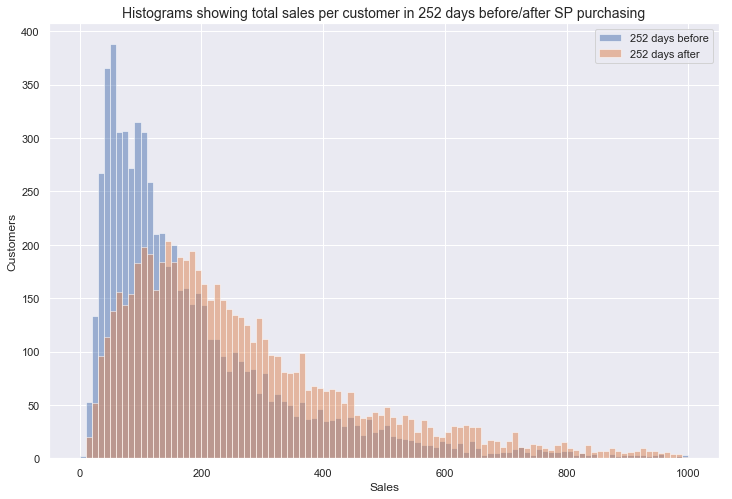

,252 days before,252 days after
count,6618.00,6618.00
mean,196.61,292.05
std,192.49,257.13
min,2.99,-5.42
25%,74.99,132.40
50%,135.96,224.88
75%,251.94,370.82
max,3205.61,4548.25


In [79]:
concat_df = pd.DataFrame()

sns.set()
plt.figure(figsize=(12,8))
plt.title('Histograms showing total sales per customer in 252 days before/after SP purchasing', fontsize=14)
plt.ylabel('Customers')
plt.xlabel('Sales')

sp_customers_252['SALES_252_BEF'].hist(bins=100, range=(0, 1000), alpha=0.5)
sp_customers_252['SALES_252_AFT'].hist(bins=100, range=(0, 1000), alpha=0.5)
plt.legend(['252 days before', '252 days after'])
concat_df = pd.concat([concat_df,
                    pd.DataFrame(sp_customers_252['SALES_252_BEF'].describe().round(2)),
                    pd.DataFrame(sp_customers_252['SALES_252_AFT'].describe().round(2)),
                        ], axis=1)
plt.show() 

concat_df.columns = ['252 days before', '252 days after']
display(concat_df)

#### AOV

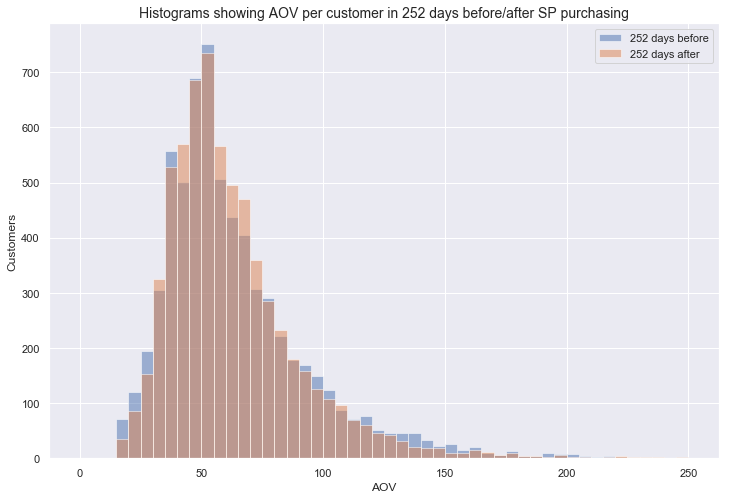

,252 days before,252 days after
count,6618.00,6618.00
mean,64.77,63.20
std,32.97,28.95
min,2.99,-5.42
25%,44.00,44.70
50%,56.03,56.72
75%,76.98,74.26
max,391.96,317.35


In [82]:
concat_df = pd.DataFrame()

sns.set()
plt.figure(figsize=(12,8))
plt.title('Histograms showing AOV per customer in 252 days before/after SP purchasing', fontsize=14)
plt.ylabel('Customers')
plt.xlabel('AOV')

sp_customers_252['AOV_252_BEF'].hist(bins=50, range=(0, 250), alpha=0.5)
sp_customers_252['AOV_252_AFT'].hist(bins=50, range=(0, 250), alpha=0.5)
plt.legend(['252 days before', '252 days after'])
concat_df = pd.concat([concat_df,
                    pd.DataFrame(sp_customers_252['AOV_252_BEF'].describe().round(2)),
                    pd.DataFrame(sp_customers_252['AOV_252_AFT'].describe().round(2)),
                        ], axis=1)
plt.show() 

concat_df.columns = ['252 days before', '252 days after']
display(concat_df)

#### Order Frequency

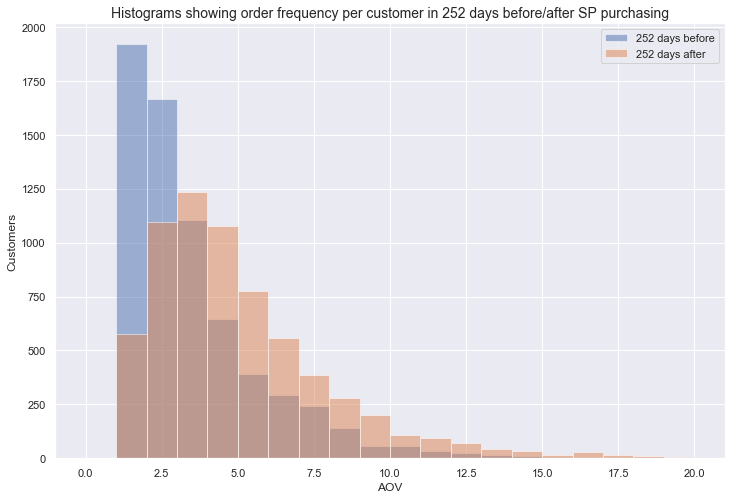

,252 days before,252 days after
count,6618.00,6618.00
mean,3.04,4.59
std,2.38,3.14
min,1.00,1.00
25%,1.00,2.00
50%,2.00,4.00
75%,4.00,6.00
max,24.00,53.00


In [83]:
concat_df = pd.DataFrame()

sns.set()
plt.figure(figsize=(12,8))
plt.title('Histograms showing order frequency per customer in 252 days before/after SP purchasing', fontsize=14)
plt.ylabel('Customers')
plt.xlabel('AOV')

sp_customers_252['OF_252_BEF'].hist(bins=20, range=(0, 20), alpha=0.5)
sp_customers_252['OF_252_AFT'].hist(bins=20, range=(0, 20), alpha=0.5)
plt.legend(['252 days before', '252 days after'])
concat_df = pd.concat([concat_df,
                    pd.DataFrame(sp_customers_252['OF_252_BEF'].describe().round(2)),
                    pd.DataFrame(sp_customers_252['OF_252_AFT'].describe().round(2)),
                        ], axis=1)
plt.show() 

concat_df.columns = ['252 days before', '252 days after']
display(concat_df)

#### CM1% & CM2%

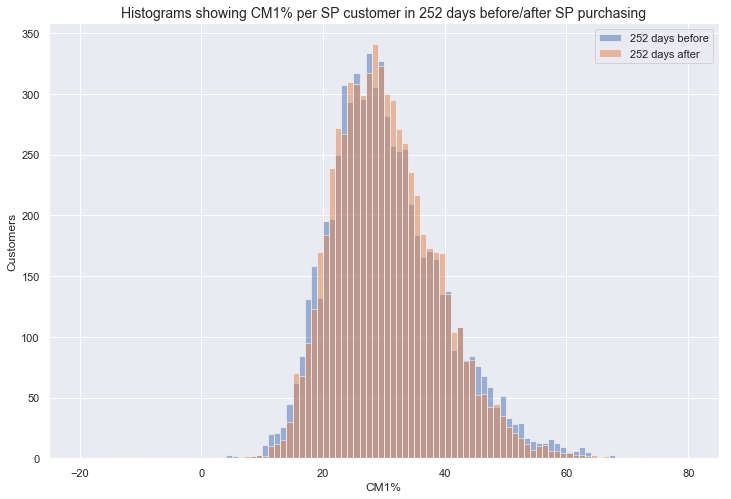

,252 days before,252 days after
count,6618.00,6618.00
mean,30.55,30.41
std,9.33,8.59
min,-0.75,-13.12
25%,24.00,24.25
50%,29.37,29.48
75%,35.97,35.56
max,100.00,111.16


In [84]:
concat_df = pd.DataFrame()

sns.set()
plt.figure(figsize=(12,8))
plt.title('Histograms showing CM1% per SP customer in 252 days before/after SP purchasing', fontsize=14)
plt.ylabel('Customers')
plt.xlabel('CM1%')

sp_customers_252['CM1%_252_BEF'].hist(bins=100, range=(-20, 80), alpha=0.5)
sp_customers_252['CM1%_252_AFT'].hist(bins=100, range=(-20, 80), alpha=0.5)
plt.legend(['252 days before', '252 days after'])
concat_df = pd.concat([concat_df,
                    pd.DataFrame(sp_customers_252['CM1%_252_BEF'].describe().round(2)),
                    pd.DataFrame(sp_customers_252['CM1%_252_AFT'].describe().round(2)),
                        ], axis=1)
plt.show() 

concat_df.columns = ['252 days before', '252 days after']
display(concat_df)

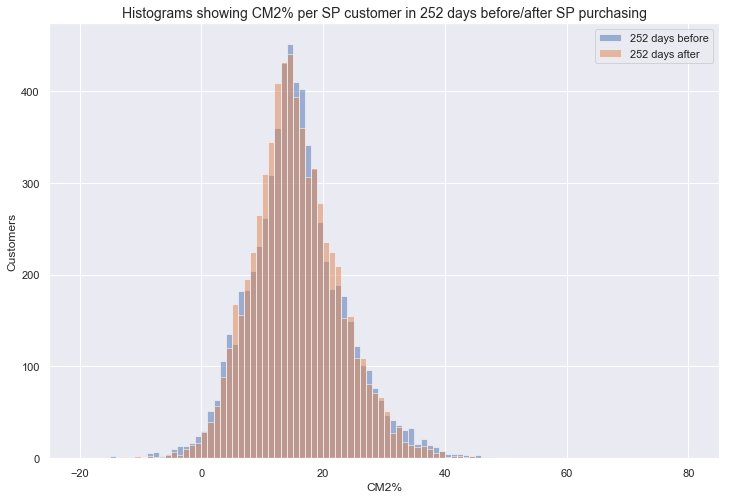

,252 days before,252 days after
count,6618.00,6618.00
mean,15.69,15.48
std,7.97,7.37
min,-74.80,-46.76
25%,10.90,10.79
50%,15.18,14.92
75%,20.05,19.84
max,100.00,118.08


In [85]:
concat_df = pd.DataFrame()

sns.set()
plt.figure(figsize=(12,8))
plt.title('Histograms showing CM2% per SP customer in 252 days before/after SP purchasing', fontsize=14)
plt.ylabel('Customers')
plt.xlabel('CM2%')

sp_customers_252['CM2%_252_BEF'].hist(bins=100, range=(-20, 80), alpha=0.5)
sp_customers_252['CM2%_252_AFT'].hist(bins=100, range=(-20, 80), alpha=0.5)
plt.legend(['252 days before', '252 days after'])
concat_df = pd.concat([concat_df,
                    pd.DataFrame(sp_customers_252['CM2%_252_BEF'].describe().round(2)),
                    pd.DataFrame(sp_customers_252['CM2%_252_AFT'].describe().round(2)),
                        ], axis=1)
plt.show() 

concat_df.columns = ['252 days before', '252 days after']
display(concat_df)

#### Number of PG3s 

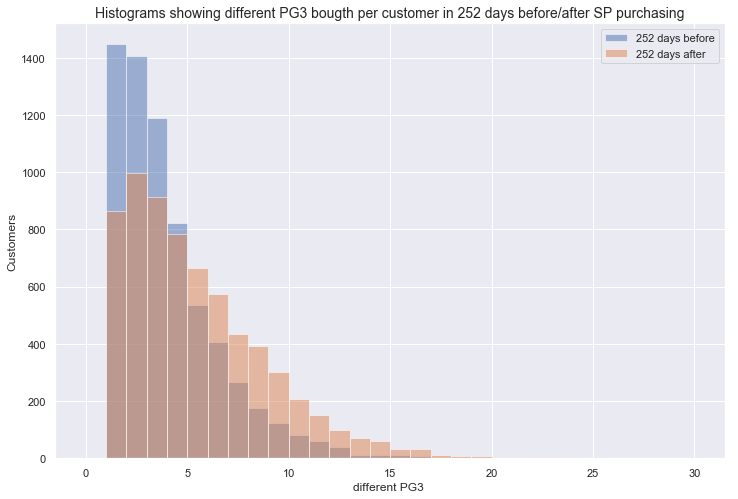

,252 days before,252 days after
count,6618.00,6618.00
mean,3.55,4.95
std,2.61,3.42
min,0.00,0.00
25%,2.00,2.00
50%,3.00,4.00
75%,5.00,7.00
max,25.00,29.00


In [86]:
concat_df = pd.DataFrame()

sns.set()
plt.figure(figsize=(12,8))
plt.title('Histograms showing different PG3 bougth per customer in 252 days before/after SP purchasing', fontsize=14)
plt.ylabel('Customers')
plt.xlabel('different PG3 ')

sp_customers_252['DIFF_PG3_252_BEF'].hist(bins=30, range=(0, 30), alpha=0.5)
sp_customers_252['DIFF_PG3_252_AFT'].hist(bins=30, range=(0, 30), alpha=0.5)
plt.legend(['252 days before', '252 days after'])
concat_df = pd.concat([concat_df,
                    pd.DataFrame(sp_customers_252['DIFF_PG3_252_BEF'].describe().round(2)),
                    pd.DataFrame(sp_customers_252['DIFF_PG3_252_AFT'].describe().round(2)),
                        ], axis=1)
plt.show() 

concat_df.columns = ['252 days before', '252 days after']
display(concat_df)

#### PG3 shares and sales in each group

In [87]:
no_sp_flat_pg3_sales = [j for i in sp_customers_252['PG3_252_BEF_FLAT_SALES'].values for j in i]

In [88]:
no_sp_pg3_sales = sorted([(pg3, np.round(sum([sales_ for pg_3_, sales_ in no_sp_flat_pg3_sales if pg3==pg_3_
                                                        ]), 3)) 
                                for pg3 in set([pg_3 for pg_3, sales in no_sp_flat_pg3_sales])], key= lambda x: x[1], reverse=True)

In [89]:
no_sp_pg3_dict_sales_no_disc = {i[0]: i[1] for i in no_sp_pg3_sales if i[0] != 0}

In [90]:
no_sp_pg3_dict_sales_share = {a: np.round(b/sum(no_sp_pg3_dict_sales_no_disc.values())*100, 3) 
                                                     for a, b in list(zip(no_sp_pg3_dict_sales_no_disc.keys(),
                                                                          no_sp_pg3_dict_sales_no_disc.values()))}

In [91]:
filter_no_sp_pg3_dict_sales_share = {x: y for x, y in list(zip(no_sp_pg3_dict_sales_share.keys(),
                                                                no_sp_pg3_dict_sales_share.values()))
                                            if y >= 1}

In [92]:
sum(filter_no_sp_pg3_dict_sales_share.values())

91.836

In [93]:
sp_flat_pg3_sales = [j for i in sp_customers_252['PG3_252_AFT_FLAT_SALES'].values for j in i]

In [94]:
sp_pg3_sales = sorted([(pg3, np.round(sum([sales_ for pg_3_, sales_ in sp_flat_pg3_sales if pg3==pg_3_
                                                        ]), 3)) 
                                for pg3 in set([pg_3 for pg_3, sales in sp_flat_pg3_sales])], key= lambda x: x[1], reverse=True)

In [95]:
sp_pg3_dict_sales_no_disc = {i[0]: i[1] for i in sp_pg3_sales if i[0] != 0}

In [96]:
sp_pg3_dict_sales_share = {a: np.round(b/sum(sp_pg3_dict_sales_no_disc.values())*100, 3) 
                                                     for a, b in list(zip(sp_pg3_dict_sales_no_disc.keys(),
                                                                          sp_pg3_dict_sales_no_disc.values()))}

In [97]:
filter_sp_pg3_dict_sales_share = {x: y for x, y in list(zip(sp_pg3_dict_sales_share.keys(),
                                                                    sp_pg3_dict_sales_share.values()))
                                            if y >= 1}

In [98]:
sum(filter_sp_pg3_dict_sales_share.values())

91.06499999999998

In [99]:
no_sp_cus_pg3_share_df = pd.DataFrame.from_dict(filter_no_sp_pg3_dict_sales_share, orient='index')
sp_cus_pg3_share_df = pd.DataFrame.from_dict(filter_sp_pg3_dict_sales_share, orient='index')

In [100]:
pg3_share_comparison = pd.concat([no_sp_cus_pg3_share_df,sp_cus_pg3_share_df], axis=1).fillna(0)
pg3_share_comparison.columns = ['NO_SP_ORD', 'SP_ORD']
pg3_share_comparison['PG3'] = pg3_share_comparison.index.values
#pg3_share_comparison['PG3'] = pg3_share_comparison['PG3'].astype(str)
pg3_share_comparison = pg3_share_comparison[['PG3', 'NO_SP_ORD', 'SP_ORD']]

In [101]:
pg3_l = list(pg3_share_comparison['PG3'].values)

In [102]:
pg3_list = repr(pg3_l).replace('[','(').replace(']',')')

In [103]:
query = """select pg_id, pg_shortlink from ZOOMAN.PRODUCT_GROUPS
where pg_id in %s""" % pg3_list

In [104]:
conn = cx_Oracle.connect('zooor', 'zoo12or', 'zoorep', threaded=True, encoding = "UTF-8", nencoding = "UTF-8")
pg3 = pd.read_sql(query, con = conn)
conn.close()

In [105]:
pg3

,PG_ID,PG_SHORTLINK
0,9,hundebett
1,15,hundeleine_hundehalsband
2,18,hundesnacks
3,20,hundespielzeug
4,23,kratzbaum_katzenbaum
5,29,katzentoilette
6,33,fressnapf
7,34,katzensnacks
8,36,katzenspielzeug
9,251,hundefutter_trockenfutter


In [106]:
pg3_dict = {x: y for x, y in list(zip(pg3['PG_ID'].values, pg3['PG_SHORTLINK'].values))}

In [107]:
pg3_share_comparison['PG3_NAME'] = [pg3_dict[i] for i in pg3_share_comparison['PG3'].values]

In [108]:
pg3_share_comparison

,PG3,NO_SP_ORD,SP_ORD,PG3_NAME
9,9,1.535,1.913,hundebett
15,15,1.000,1.236,hundeleine_hundehalsband
18,18,3.846,3.011,hundesnacks
20,20,1.122,1.231,hundespielzeug
23,23,2.696,4.564,kratzbaum_katzenbaum
29,29,1.745,2.165,katzentoilette
33,33,1.112,1.534,fressnapf
34,34,1.392,1.187,katzensnacks
36,36,1.458,1.946,katzenspielzeug
251,251,26.001,23.156,hundefutter_trockenfutter


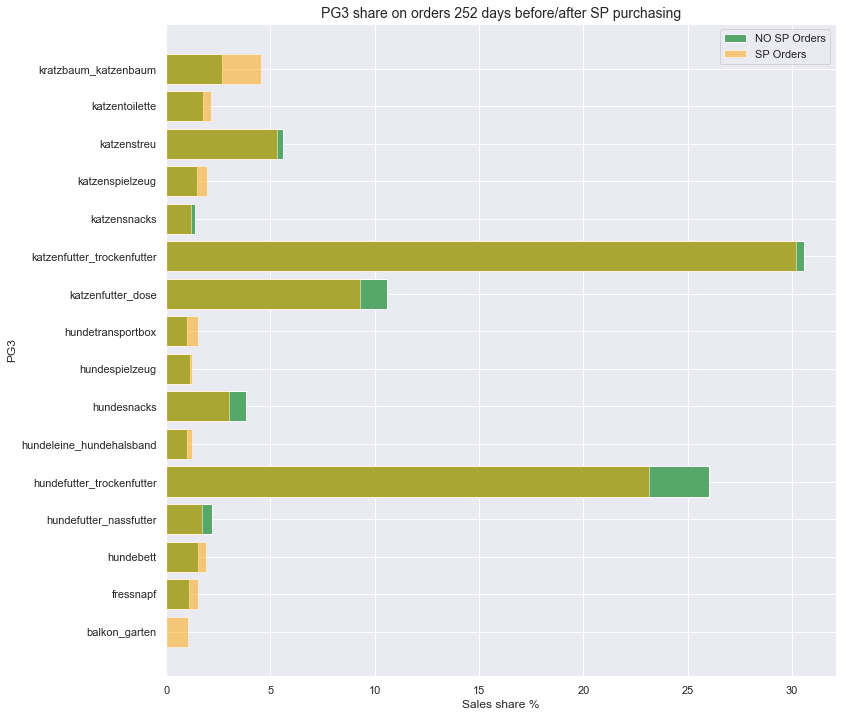

In [109]:
plt.figure(figsize=(12, 12))
x = pg3_share_comparison['PG3_NAME'].values
y = pg3_share_comparison['NO_SP_ORD'].values
z = pg3_share_comparison['SP_ORD'].values
plt.barh(x, y, color='g')
plt.barh(x, z, color='orange', alpha=0.5)
plt.title('PG3 share on orders 252 days before/after SP purchasing', fontsize=14)
plt.ylabel('PG3')
plt.xlabel('Sales share %')
plt.legend(['NO SP Orders', 'SP Orders'])
plt.show()

In [110]:
no_sp_cus_pg3_sales_df = pd.DataFrame.from_dict(no_sp_pg3_dict_sales_no_disc, orient='index')
sp_cus_pg3_sales_df = pd.DataFrame.from_dict(sp_pg3_dict_sales_no_disc, orient='index')

In [111]:
pg3_sales_comparison = pd.concat([no_sp_cus_pg3_sales_df, sp_cus_pg3_sales_df], axis=1).fillna(0)
pg3_sales_comparison.columns = ['NO_SP_ORD', 'SP_ORD']
pg3_sales_comparison['PG3'] = pg3_sales_comparison.index.values
#pg3_sales_comparison['PG3'] = pg3_sales_comparison['PG3'].astype(str)

In [112]:
pg3_lis = list(pg3_sales_comparison['PG3'].values)

In [113]:
pg3_lista = repr(pg3_lis).replace('[','(').replace(']',')')

In [114]:
query = """select pg_id, pg_shortlink from ZOOMAN.PRODUCT_GROUPS
where pg_id in %s""" % pg3_lista

In [115]:
conn = cx_Oracle.connect('zooor', 'zoo12or', 'zoorep', threaded=True, encoding = "UTF-8", nencoding = "UTF-8")
pg3 = pd.read_sql(query, con = conn)
conn.close()

In [116]:
pg3_dict = {x: y for x, y in list(zip(pg3['PG_ID'].values, pg3['PG_SHORTLINK'].values))}

In [117]:
pg3_sales_comparison['PG3_NAME'] = [pg3_dict[i] for i in pg3_sales_comparison['PG3'].values]

In [118]:
pg3_sales_comparison = pg3_sales_comparison[['PG3', 'PG3_NAME', 'NO_SP_ORD', 'SP_ORD']]
pg3_sales_comparison = pg3_sales_comparison[(pg3_sales_comparison['NO_SP_ORD'] >= 1000) | (pg3_sales_comparison['SP_ORD'] >= 1000)]

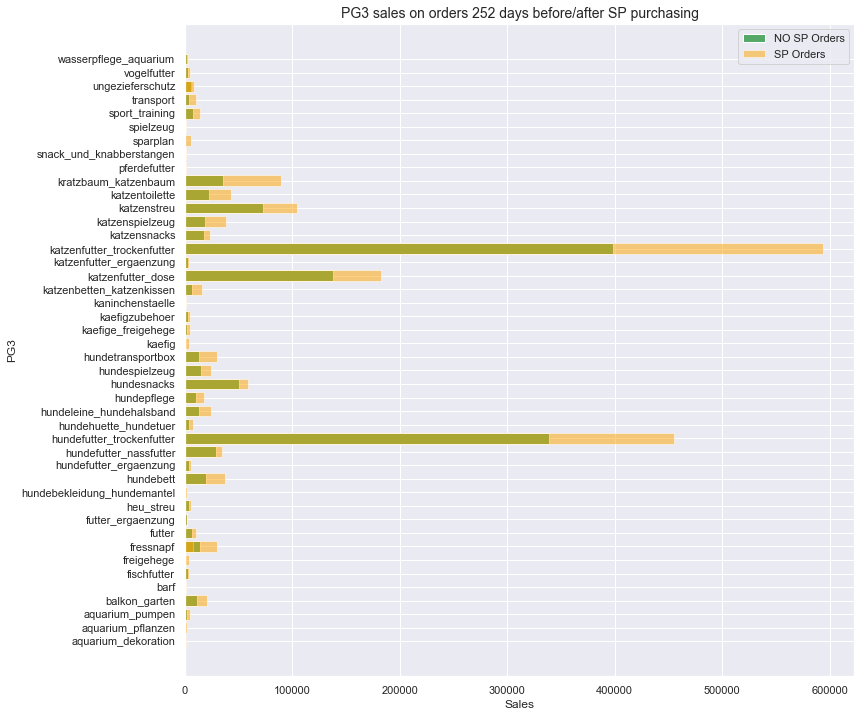

In [119]:
plt.figure(figsize=(12, 12))
x = pg3_sales_comparison['PG3_NAME'].values
y = pg3_sales_comparison['NO_SP_ORD'].values
z = pg3_sales_comparison['SP_ORD'].values
plt.barh(x, y, color='g')
plt.barh(x, z, color='orange', alpha=0.5)
plt.title('PG3 sales on orders 252 days before/after SP purchasing', fontsize=14)
plt.ylabel('PG3')
plt.xlabel('Sales')
plt.legend(['NO SP Orders', 'SP Orders'])
plt.show()

In [120]:
pg3_sales_comparison

,PG3,PG3_NAME,NO_SP_ORD,SP_ORD
9,9,hundebett,20023.50,37588.29
15,15,hundeleine_hundehalsband,13050.42,24292.75
16,16,fressnapf,3722.65,7476.38
18,18,hundesnacks,50178.43,59182.95
20,20,hundespielzeug,14632.19,24188.50
23,23,kratzbaum_katzenbaum,35167.17,89694.09
29,29,katzentoilette,22770.34,42541.83
33,33,fressnapf,14507.99,30149.13
34,34,katzensnacks,18161.28,23331.49
36,36,katzenspielzeug,19025.42,38243.46


#### Average Sales Share of Royal Canin products – 252 days orders before/after SP purchasing

In [121]:
sp_customers_252['BRAND_SALES_252_BEF'] = [list(compress(i, j)) for i, j in list(zip(sp_customers_252['BRAND_AGGSALES'],
                                                                                    sp_customers_252['MASK_252_BEF']))]

In [122]:
sp_customers_252['BRAND_SALES_252_AFT'] = [list(compress(i, j)) for i, j in list(zip(sp_customers_252['BRAND_AGGSALES'],
                                                                                    sp_customers_252['MASK_252_AFT']))]

In [123]:
sp_customers_252['BRAND_FLAT_SALES_252_BEF'] = [[k for j in i for k in j] 
                                                for i in sp_customers_252['BRAND_SALES_252_BEF'].values]

In [124]:
sp_customers_252['BRAND_FLAT_SALES_252_AFT'] = [[k for j in i for k in j] 
                                                for i in sp_customers_252['BRAND_SALES_252_AFT'].values]

In [125]:
no_sp_flat_brand_sales = [j for i in sp_customers_252['BRAND_FLAT_SALES_252_BEF'].values for j in i]

In [126]:
sp_flat_brand_sales = [j for i in sp_customers_252['BRAND_FLAT_SALES_252_AFT'].values for j in i]

In [127]:
no_sp_brand_sales = sorted([(brand_, np.round(sum([sales_ for brand__, sales_ in no_sp_flat_brand_sales if brand_== brand__
                                                        ]), 3)) 
                                for brand_ in set([brand for brand, sales in no_sp_flat_brand_sales])], key= lambda x: x[1], reverse=True) 

In [128]:
sp_brand_sales = sorted([(brand_, np.round(sum([sales_ for brand__, sales_ in sp_flat_brand_sales if brand_== brand__
                                                        ]), 3)) 
                                for brand_ in set([brand for brand, sales in sp_flat_brand_sales])], key= lambda x: x[1], reverse=True) 

In [129]:
no_sp_dict_sales_no_disc = {i[0]: i[1] for i in no_sp_brand_sales if str(i[0]) != 'nan'}

In [130]:
sp_dict_sales_no_disc = {i[0]: i[1] for i in sp_brand_sales if str(i[0]) != 'nan'}

In [131]:
no_sp_dict_sales_share = {a: np.round(b/sum(no_sp_dict_sales_no_disc.values())*100, 3)
                         for a, b in list(zip(no_sp_dict_sales_no_disc.keys(),
                                             no_sp_dict_sales_no_disc.values()))}

In [132]:
sp_dict_sales_share = {a: np.round(b/sum(sp_dict_sales_no_disc.values())*100, 3)
                         for a, b in list(zip(sp_dict_sales_no_disc.keys(),
                                             sp_dict_sales_no_disc.values()))}

In [133]:
sum(no_sp_dict_sales_share.values()), sum(sp_dict_sales_share.values())

(99.99600000000014, 99.99600000000004)

In [134]:
brands = pd.read_csv('pg4_brands.dsv', sep=';', low_memory=False)

In [135]:
brands['BRAND'] = [i.split(' - ')[1] if len(i.split('-')) > 1 else 'unknown' for i in brands['PPR_V_LEVEL4_DESC'].values]

In [136]:
brands.head()

,PPR_N_LEVEL4_ID,PPR_V_LEVEL4_DESC,BRAND
0,20745,20745 - Hundesofa,Hundesofa
1,2,2 - Hund,Hund
2,1422,1422 - Spielzeug,Spielzeug
3,75,75 - Hundekissen,Hundekissen
4,2157,2157 - Alle Katzenklappen,Alle Katzenklappen


In [137]:
RC_brands = brands[brands['BRAND'].str.contains('Royal Canin')][['PPR_N_LEVEL4_ID', 'BRAND']]
RC_brands

,PPR_N_LEVEL4_ID,BRAND
185,126742,Royal Canin Dog
257,17798,Royal Canin Breed (Rasse)
274,1308,Royal Canin Club / Selection
296,9702,Royal Canin Pure Feline
444,81396,Royal Canin Veterinary Diet
449,82696,Royal Canin Veterinary Diet
477,209912,Royal Canin Vet Care Nutrition
710,127037,Royal Canin Universal
790,682,Royal Canin Size
952,94525,Royal Canin


In [138]:
no_sp_rc_share_dict = {a: b for a, b in list(zip(no_sp_dict_sales_share.keys(), 
                                                 no_sp_dict_sales_share.values()))
                      if a in RC_brands['BRAND'].values}

In [139]:
no_sp_rc_share_dict

{'Royal Canin': 13.971,
 'Royal Canin Breed (Rasse)': 3.136,
 'Royal Canin Club / Selection': 0.151,
 'Royal Canin Dog': 0.001,
 'Royal Canin Pure Feline': 0.065,
 'Royal Canin Rasse (Breed)': 3.737,
 'Royal Canin Size': 3.96,
 'Royal Canin Vet Care Nutrition': 0.666,
 'Royal Canin Veterinary Diet': 8.117}

In [140]:
sp_rc_share_dict = {a: b for a, b in list(zip(sp_dict_sales_share.keys(), 
                                            sp_dict_sales_share.values()))
                      if a in RC_brands['BRAND'].values}

In [141]:
sp_rc_share_dict

{'Royal Canin': 14.289,
 'Royal Canin Breed (Rasse)': 2.938,
 'Royal Canin Cat': 0.002,
 'Royal Canin Club / Selection': 0.162,
 'Royal Canin Dog': 0.002,
 'Royal Canin Pure Feline': 0.059,
 'Royal Canin Rasse (Breed)': 3.828,
 'Royal Canin Size': 3.786,
 'Royal Canin Vet Care Nutrition': 0.548,
 'Royal Canin Veterinary Diet': 7.485}

In [142]:
no_sp_rc_share_df = pd.DataFrame.from_dict(no_sp_rc_share_dict, orient='index')
sp_rc_share_df = pd.DataFrame.from_dict(sp_rc_share_dict, orient='index')

In [143]:
rc_comparison = pd.concat([no_sp_rc_share_df, sp_rc_share_df], axis=1).fillna(0)
rc_comparison.columns = ['NO_SP_ORD', 'SP_ORD']
rc_comparison['BRAND'] = rc_comparison.index.values
rc_comparison = rc_comparison[['BRAND', 'NO_SP_ORD', 'SP_ORD']]
rc_comparison

,BRAND,NO_SP_ORD,SP_ORD
Royal Canin,Royal Canin,13.971,14.289
Royal Canin Breed (Rasse),Royal Canin Breed (Rasse),3.136,2.938
Royal Canin Cat,Royal Canin Cat,0.000,0.002
Royal Canin Club / Selection,Royal Canin Club / Selection,0.151,0.162
Royal Canin Dog,Royal Canin Dog,0.001,0.002
Royal Canin Pure Feline,Royal Canin Pure Feline,0.065,0.059
Royal Canin Rasse (Breed),Royal Canin Rasse (Breed),3.737,3.828
Royal Canin Size,Royal Canin Size,3.960,3.786
Royal Canin Vet Care Nutrition,Royal Canin Vet Care Nutrition,0.666,0.548
Royal Canin Veterinary Diet,Royal Canin Veterinary Diet,8.117,7.485


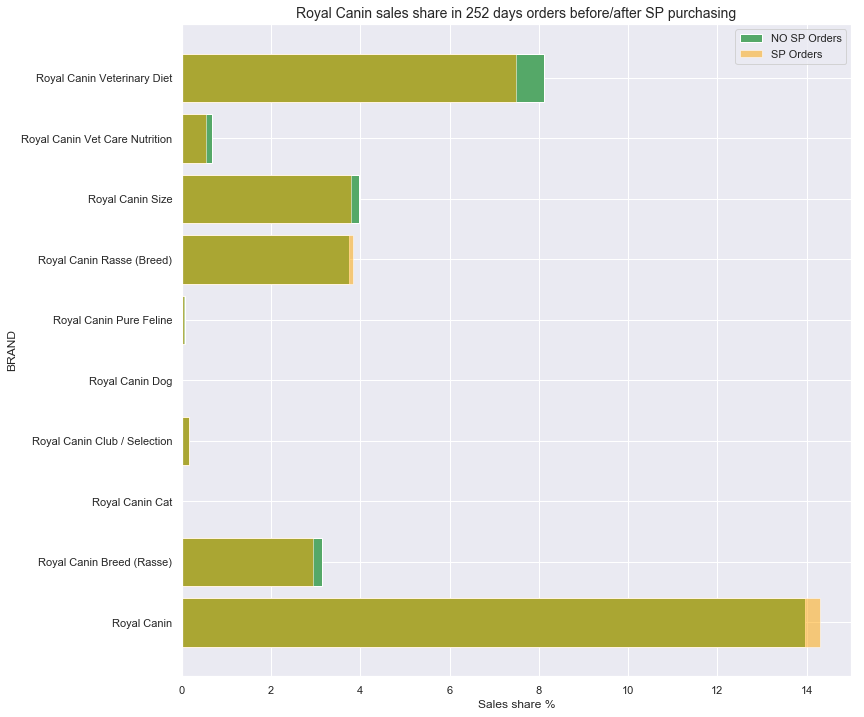

In [144]:
plt.figure(figsize=(12, 12))
x = rc_comparison['BRAND'].values
y = rc_comparison['NO_SP_ORD'].values
z = rc_comparison['SP_ORD'].values
plt.barh(x, y, color='g')
plt.barh(x, z, color='orange', alpha=0.5)
plt.title('Royal Canin sales share in 252 days orders before/after SP purchasing', fontsize=14)
plt.ylabel('BRAND')
plt.xlabel('Sales share %')
plt.legend(['NO SP Orders', 'SP Orders'])
plt.show()

#### Royal Canin sales -  252 days orders before/after SP purchasing

In [145]:
no_sp_rc_sales_dict = {a: b for a, b in list(zip(no_sp_dict_sales_no_disc.keys(), 
                                            no_sp_dict_sales_no_disc.values()))
                      if a in RC_brands['BRAND'].values}

In [146]:
no_sp_rc_sales_dict

{'Royal Canin': 182266.87,
 'Royal Canin Breed (Rasse)': 40917.1,
 'Royal Canin Club / Selection': 1975.18,
 'Royal Canin Dog': 11.0,
 'Royal Canin Pure Feline': 850.46,
 'Royal Canin Rasse (Breed)': 48757.48,
 'Royal Canin Size': 51657.33,
 'Royal Canin Vet Care Nutrition': 8692.62,
 'Royal Canin Veterinary Diet': 105894.62}

In [147]:
sp_rc_sales_dict = {a: b for a, b in list(zip(sp_dict_sales_no_disc.keys(), 
                                            sp_dict_sales_no_disc.values()))
                      if a in RC_brands['BRAND'].values}

In [148]:
sp_rc_sales_dict

{'Royal Canin': 280816.24,
 'Royal Canin Breed (Rasse)': 57732.74,
 'Royal Canin Cat': 45.01,
 'Royal Canin Club / Selection': 3192.22,
 'Royal Canin Dog': 33.87,
 'Royal Canin Pure Feline': 1160.4,
 'Royal Canin Rasse (Breed)': 75235.62,
 'Royal Canin Size': 74411.9,
 'Royal Canin Vet Care Nutrition': 10768.59,
 'Royal Canin Veterinary Diet': 147097.77}

In [149]:
no_sp_rc_sales_df = pd.DataFrame.from_dict(no_sp_rc_sales_dict, orient='index')
sp_rc_sales_df = pd.DataFrame.from_dict(sp_rc_sales_dict, orient='index')

In [150]:
rc_sales_comparison = pd.concat([no_sp_rc_sales_df, sp_rc_sales_df], axis=1).fillna(0)
rc_sales_comparison.columns = ['NO_SP_ORD', 'SP_ORD']
rc_sales_comparison['BRAND'] = rc_sales_comparison.index.values
rc_sales_comparison = rc_sales_comparison[['BRAND', 'NO_SP_ORD', 'SP_ORD']]
rc_sales_comparison

,BRAND,NO_SP_ORD,SP_ORD
Royal Canin,Royal Canin,182266.87,280816.24
Royal Canin Breed (Rasse),Royal Canin Breed (Rasse),40917.10,57732.74
Royal Canin Cat,Royal Canin Cat,0.00,45.01
Royal Canin Club / Selection,Royal Canin Club / Selection,1975.18,3192.22
Royal Canin Dog,Royal Canin Dog,11.00,33.87
Royal Canin Pure Feline,Royal Canin Pure Feline,850.46,1160.40
Royal Canin Rasse (Breed),Royal Canin Rasse (Breed),48757.48,75235.62
Royal Canin Size,Royal Canin Size,51657.33,74411.90
Royal Canin Vet Care Nutrition,Royal Canin Vet Care Nutrition,8692.62,10768.59
Royal Canin Veterinary Diet,Royal Canin Veterinary Diet,105894.62,147097.77


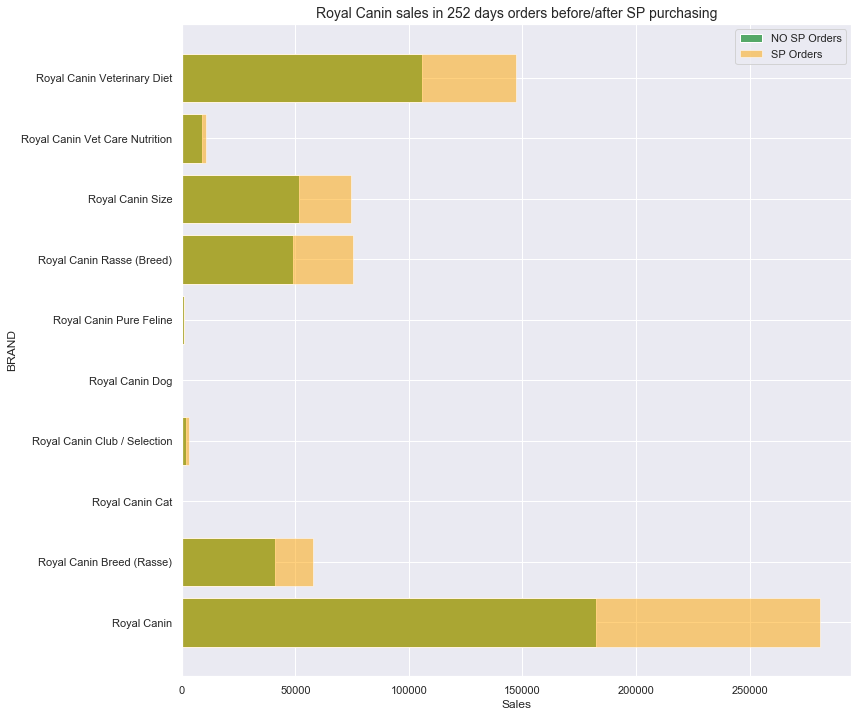

In [151]:
plt.figure(figsize=(12, 12))
x = rc_sales_comparison['BRAND'].values
y = rc_sales_comparison['NO_SP_ORD'].values
z = rc_sales_comparison['SP_ORD'].values
plt.barh(x, y, color='g')
plt.barh(x, z, color='orange', alpha=0.5)
plt.title('Royal Canin sales in 252 days orders before/after SP purchasing', fontsize=14)
plt.ylabel('BRAND')
plt.xlabel('Sales')
plt.legend(['NO SP Orders', 'SP Orders'])
plt.show()

#### Average Sales Share of Hill's products – 252 days orders before/after SP purchasing

In [152]:
Hills_brands = brands[brands['BRAND'].str.contains("Hill's")][['PPR_N_LEVEL4_ID', 'BRAND']]
Hills_brands

,PPR_N_LEVEL4_ID,BRAND
13,719,Hill's Science Plan
188,84729,Hill's Prescription Diet
261,1816,Hill's Puppy & Senior
270,2058,Hill's Natures Best
295,720,Hill's Science Plan
472,151599,Hill's Prescription Diet
735,175240,Hill's Ideal Balance
736,177843,Hill's Ideal Balance
1150,31962,Hill's Prescription Diet
1381,31963,Hill's Prescription Diet


In [153]:
no_sp_hills_share_dict = {a: b for a, b in list(zip(no_sp_dict_sales_share.keys(), 
                                                 no_sp_dict_sales_share.values()))
                      if a in Hills_brands['BRAND'].values}

In [154]:
no_sp_hills_share_dict

{"Hill's Ideal Balance": 0.216,
 "Hill's Natures Best": 0.064,
 "Hill's Prescription Diet": 6.158,
 "Hill's Science Plan": 4.303,
 "Nature's Best von Hill's": 0.039}

In [155]:
sp_hills_share_dict = {a: b for a, b in list(zip(sp_dict_sales_share.keys(), 
                                                 sp_dict_sales_share.values()))
                      if a in Hills_brands['BRAND'].values}

In [156]:
sp_hills_share_dict

{"Hill's Ideal Balance": 0.185,
 "Hill's Natures Best": 0.072,
 "Hill's Prescription Diet": 5.478,
 "Hill's Science Plan": 4.138,
 "Nature's Best von Hill's": 0.043}

In [157]:
no_sp_hills_share_df = pd.DataFrame.from_dict(no_sp_hills_share_dict, orient='index')
sp_hills_share_df = pd.DataFrame.from_dict(sp_hills_share_dict, orient='index')

In [158]:
hills_comparison = pd.concat([no_sp_hills_share_df, sp_hills_share_df], axis=1).fillna(0)
hills_comparison.columns = ['NO_SP_ORD', 'SP_ORD']
hills_comparison['BRAND'] = hills_comparison.index.values
hills_comparison = hills_comparison[['BRAND', 'NO_SP_ORD', 'SP_ORD']]
hills_comparison

,BRAND,NO_SP_ORD,SP_ORD
Hill's Prescription Diet,Hill's Prescription Diet,6.158,5.478
Hill's Science Plan,Hill's Science Plan,4.303,4.138
Hill's Ideal Balance,Hill's Ideal Balance,0.216,0.185
Hill's Natures Best,Hill's Natures Best,0.064,0.072
Nature's Best von Hill's,Nature's Best von Hill's,0.039,0.043


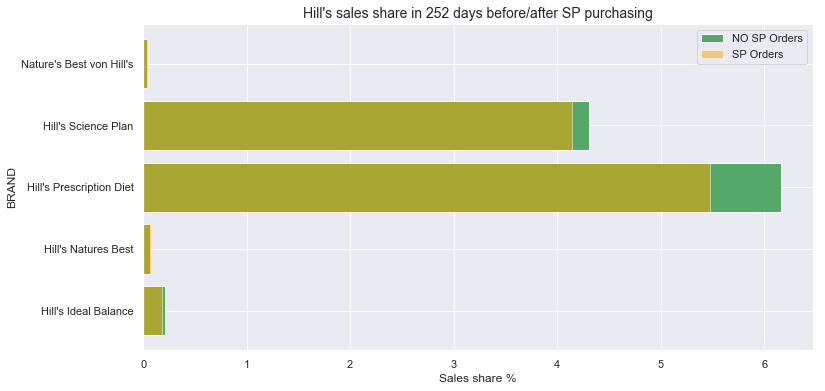

In [159]:
plt.figure(figsize=(12, 6))
x = hills_comparison['BRAND'].values
y = hills_comparison['NO_SP_ORD'].values
z = hills_comparison['SP_ORD'].values
plt.barh(x, y, color='g')
plt.barh(x, z, color='orange', alpha=0.5)
plt.title("Hill's sales share in 252 days before/after SP purchasing", fontsize=14)
plt.ylabel('BRAND')
plt.xlabel('Sales share %')
plt.legend(['NO SP Orders', 'SP Orders'])
plt.show()

#### Hill's sales -  252 days orders before/after SP purchasing

In [160]:
no_sp_hills_sales_dict = {a: b for a, b in list(zip(no_sp_dict_sales_no_disc.keys(), 
                                            no_sp_dict_sales_no_disc.values()))
                      if a in Hills_brands['BRAND'].values}

In [161]:
no_sp_hills_sales_dict

{"Hill's Ideal Balance": 2812.23,
 "Hill's Natures Best": 834.85,
 "Hill's Prescription Diet": 80340.14,
 "Hill's Science Plan": 56137.33,
 "Nature's Best von Hill's": 507.79}

In [162]:
sp_hills_sales_dict = {a: b for a, b in list(zip(sp_dict_sales_no_disc.keys(), 
                                            sp_dict_sales_no_disc.values()))
                      if a in Hills_brands['BRAND'].values}

In [163]:
sp_hills_sales_dict

{"Hill's Ideal Balance": 3628.85,
 "Hill's Natures Best": 1415.76,
 "Hill's Prescription Diet": 107669.56,
 "Hill's Science Plan": 81325.77,
 "Nature's Best von Hill's": 851.68}

In [164]:
no_sp_hills_sales_df = pd.DataFrame.from_dict(no_sp_hills_sales_dict, orient='index')
sp_hills_sales_df = pd.DataFrame.from_dict(sp_hills_sales_dict, orient='index')

In [165]:
hills_sales_comparison = pd.concat([no_sp_hills_sales_df, sp_hills_sales_df], axis=1).fillna(0)
hills_sales_comparison.columns = ['NO_SP_ORD', 'SP_ORD']
hills_sales_comparison['BRAND'] = hills_sales_comparison.index.values
hills_sales_comparison = hills_sales_comparison[['BRAND', 'NO_SP_ORD', 'SP_ORD']]
hills_sales_comparison

,BRAND,NO_SP_ORD,SP_ORD
Hill's Prescription Diet,Hill's Prescription Diet,80340.14,107669.56
Hill's Science Plan,Hill's Science Plan,56137.33,81325.77
Hill's Ideal Balance,Hill's Ideal Balance,2812.23,3628.85
Hill's Natures Best,Hill's Natures Best,834.85,1415.76
Nature's Best von Hill's,Nature's Best von Hill's,507.79,851.68


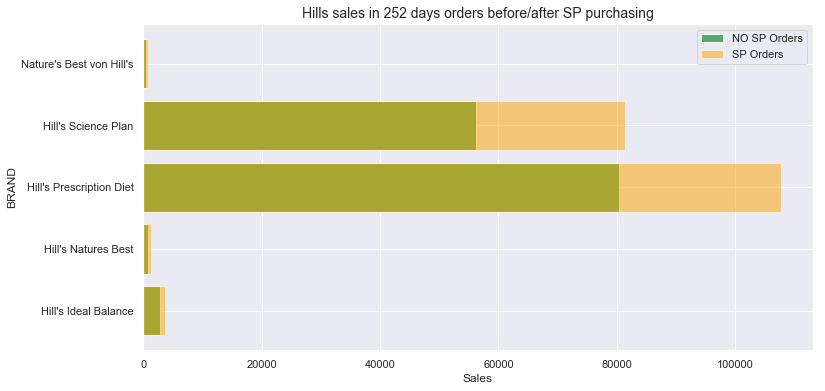

In [166]:
plt.figure(figsize=(12, 6))
x = hills_sales_comparison['BRAND'].values
y = hills_sales_comparison['NO_SP_ORD'].values
z = hills_sales_comparison['SP_ORD'].values
plt.barh(x, y, color='g')
plt.barh(x, z, color='orange', alpha=0.5)
plt.title('Hills sales in 252 days orders before/after SP purchasing', fontsize=14)
plt.ylabel('BRAND')
plt.xlabel('Sales')
plt.legend(['NO SP Orders', 'SP Orders'])
plt.show()

##### Timedeltas between orders before/after SP purchasing (every data available for the customer, not only 252 days)

In [167]:
sp_customers_252.columns

Index(['CUS_N_KEY_CUSTOMER', 'SCM_N_ORDER_NR_len', 'TDT_T_KEY_ORDER_DATE_list',
       'SCM_SALES_BMF_sum', 'SCM_SALES_BMF_list', 'SCM_D_FINANCE_CM1_sum',
       'SCM_D_FINANCE_CM1_list', 'SCM_D_FINANCE_CM2_sum',
       'SCM_D_FINANCE_CM2_list', 'SCM_D_ORIG_FINANCE_ORDER_NET_sum',
       'SCM_D_ORIG_FINANCE_ORDER_NET_list', 'OSP_KO_COUNT_NET_list',
       'SCM_MASTER_AP_ID_list', 'CZP_ZTQ_ID', 'CZP_START_DATE',
       'CZP_EXPIRY_DATE', 'PG3_AGGSALES', 'PG4_AGGSALES', 'BRAND_AGGSALES',
       'SP_PURCHASE', 'SP_DISC', 'D28', 'D56', 'D84', 'D168', 'D252', 'D336',
       'O_TIMEDELTAS', 'FLAT_PG3_SALES', 'FLAT_PG4_SALES', 'FLAT_BRAND_SALES',
       'TOTAL_PG3_SALES', 'TOTAL_PG4_SALES', 'TOTAL_BRAND_SALES', 'SP_PY_POS',
       'DAYS_UNTIL_1st_SP', 'SP_ORDERS', 'NO_SP_ORDERS', 'DAYS_IN_DF',
       'DAYS_AFTER_1st_SP', 'SP_CUS', 'MASK_252_BEF', 'MASK_252_AFT',
       'ONE_ORDER_BEFORE', 'SALES_252_BEF', 'SALES_252_AFT', 'AOV_252_BEF',
       'AOV_252_AFT', 'OF_252_BEF', 'OF_252_AFT', 'CM1_2

In [168]:
sp_customers_252['TD_BEFORE_SP'] = [x[:(y-1)] for x, y in list(zip(sp_customers_252['O_TIMEDELTAS'],
                                               sp_customers_252['SP_PY_POS']))]

In [169]:
sp_customers_252['TD_AFTER_SP'] = [x[(y-1):] for x, y in list(zip(sp_customers_252['O_TIMEDELTAS'],
                                               sp_customers_252['SP_PY_POS']))]

In [170]:
td_before_sp = [j for i in sp_customers_252['TD_BEFORE_SP'].values for j in i]

In [171]:
td_after_sp = [j for i in sp_customers_252['TD_AFTER_SP'].values for j in i]

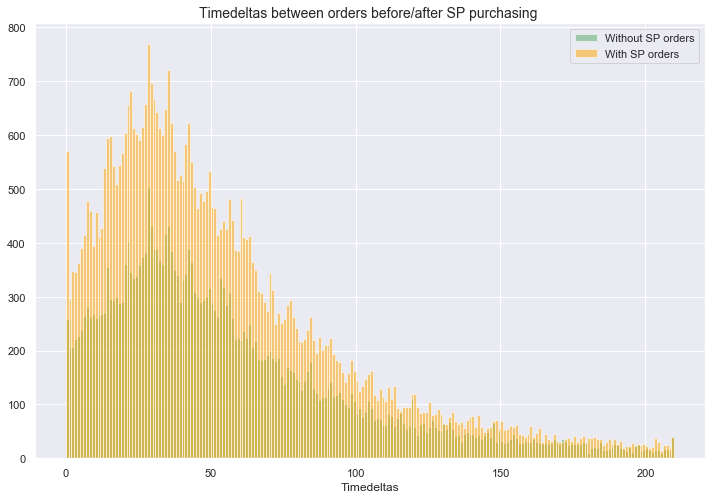

,Without SP orders,With SP orders
25%,26.00,25.00
50%,48.00,45.00
75%,85.00,77.00
count,31247.00,49685.00
max,799.00,660.00
mean,69.55,59.42
min,0.00,0.00
std,74.22,53.24


In [172]:
concat_df = pd.DataFrame()

plt.figure(figsize=(12, 8))
plt.hist(td_before_sp, bins=210, range=(0, 210), color='g', alpha=0.5)
plt.hist(td_after_sp, bins=210, range=(0, 210), color='orange', alpha=0.5)
plt.title("Timedeltas between orders before/after SP purchasing ", fontsize=14)
plt.xlabel('Timedeltas')
plt.legend(['Without SP orders', 'With SP orders'])
plt.show()

before_sp_td = pd.DataFrame(np.array(td_before_sp).reshape(len(td_before_sp), 1), columns= ['TD_BEFORE_SP'])
after_sp_td = pd.DataFrame(np.array(td_after_sp).reshape(len(td_after_sp), 1), columns= ['TD_AFTER_SP'])

concat_df = pd.concat([concat_df,
                    before_sp_td['TD_BEFORE_SP'].describe().round(2),
                    after_sp_td['TD_AFTER_SP'].describe().round(2),
                      ], axis=1)

concat_df.columns = ['Without SP orders', 'With SP orders']
display(concat_df)